<a href="https://colab.research.google.com/github/JuanM-GG/sistemas-dinamicos-R/blob/main/modelo_fed_batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Modelo biorreactor lote-alimentado

Autor: Juan Manuel Gutiérrez García

Fecha:  Enero 2021

En el siguiente cuaderno describimos el modelado y la optimización de un biorreactor tipo lote-alimentado. En este biorreactor se tiene un flujo de alimentación $F_{in}$ pero no un flujo de salida. Se considera que en la alimentación se introduce unicamente sustrato ($s$). En el interior del biorreactor ocurren dos reacciones que dan lugar a la formación de biomasa ($x$) y producto ($p$).

 

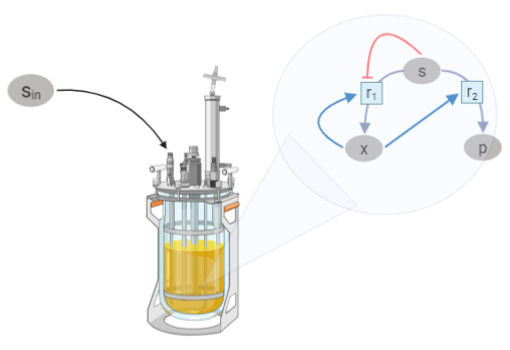

Figura 1. Esquema de un biorreactor tipo lote-alimentado 

# Modelado de ecuaciones

El modelo dinámico se desarrolla escribiendo balances de materia para la masa total en el biorreactor, la biomasa (células), el sustrato (fuente de alimentación para las células) y el producto (metabolito generado). La biomasa crece alimentándose del sustrato.

Balance de materia total

$$acumulacion\ de\ masa\ =\ entrada\ por\ flujo\ -\ salida\ por\ flujo\ $$

$$\frac{d(\rho V)}{dt} = F \rho  $$

Balance de materia para la biomasa 

$$acumulacion\ de\ biomasa\ =\ entrada\ por\ flujo\ -\ salida\ por\ flujo\ +\ generación$$

$$\frac{d(xV)}{dt} = F x_f + V r_x $$

Balance de materia para el producto 

$$acumulacion\ de\ producto\ =\ entrada\ por\ flujo\ -\ salida\ por\ flujo\ +\ generación$$

$$\frac{d(pV)}{dt} =  F p_f + V r_p $$

Balance de materia para el sustrato 

$$acumulacion\ de\ sustrato\ =\ entrada\ por\ flujo\ -\ salida\ por\ flujo\ -\ consumo$$

$$ \frac{d(sV)}{dt} = F s_f - V r_s $$


Consideramos que en el flujo de alimentación no existe biomasa ni producto. Además, a partir de la definición de los rendimientos

$$Y_{xs} = \frac{r_x}{r_s} \hspace{1cm} y \hspace{1cm} Y_{px} = \frac{r_p}{r_x}$$

Donde $Y_{xs}$ y $Y_{px}$ son los rendimientos biomasa-sustrato y producto-biomasa, respectivamente. Desarrollando y simplificando, reescribimos las ecuaciones (1)-(4) como 
$$
\begin{aligned}

\frac{dV}{dt} &= F  \\

\frac{dx}{dt} &=  -\frac{F}{V}x +  r_x \\

\frac{dp}{dt} &=  -\frac{F}{V}p +  Y_{xp} r_x \\

\frac{ds}{dt} &= \frac{F}{V} (s_f - s) -  \frac{r_x}{Y_{xs}} 
\end{aligned}
$$

# Tasa de crecimiento específica
La velocidad de reacción (masa de células generadas / tiempo * volumen) se escribe normalmente como

$$
r_x = \mu(s) x 
$$
donde $ \mu $ es el coeficiente de tasa de crecimiento específico. Podemos pensar en $\mu$ como similar a una constante de velocidad de reacción de primer orden; sin embargo, $\mu$ no es constante, es una función de la concentración de sustrato. Las unidades de $\mu$ son $tiempo^{- 1} $.

# Expresiones de tasa de crecimiento

El coeficiente de la tasa de crecimiento no suele ser constante. Se han desarrollado varias relaciones funcionales entre el coeficiente de tasa de crecimiento y la concentración de sustrato. Los más comunes son (i) Monod y (ii) Inhibición por sustrato.

### Modelo con inhibición por sustrato

En este caso usamos el modelo de inhibición por sustrato el cual describe la tasa específica de crecimeinto como la siguiente función no monótona de la concentración de sustrato 

$$\mu(s) = \frac{\mu_{max} s}{k_s + s + k_i s^2}$$

In [94]:
# cargar librerias 
install.packages("deSolve")
library(deSolve)
install.packages("ggplot2")
library(ggplot2)
install.packages("xlsx")
library(xlsx)
install.packages("GA")
library(GA)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [95]:
# ecuación de inhibición por sustrato  
subinhib <- function(s) {

  mu = mu_max*s/(ks + s + ki*s^2)

  return(mu)
}

In [96]:
# establecer parámetros
mu_max <- 0.53 # h^-1
ks <- 0.12 # g/L
ki <- 0.4545 # g/L
sf <- 4.0 # g/L

In [97]:
s <- seq(0,5,len=100)
mu <- subinhib(s)
data <- data.frame(s = s, mu = mu)

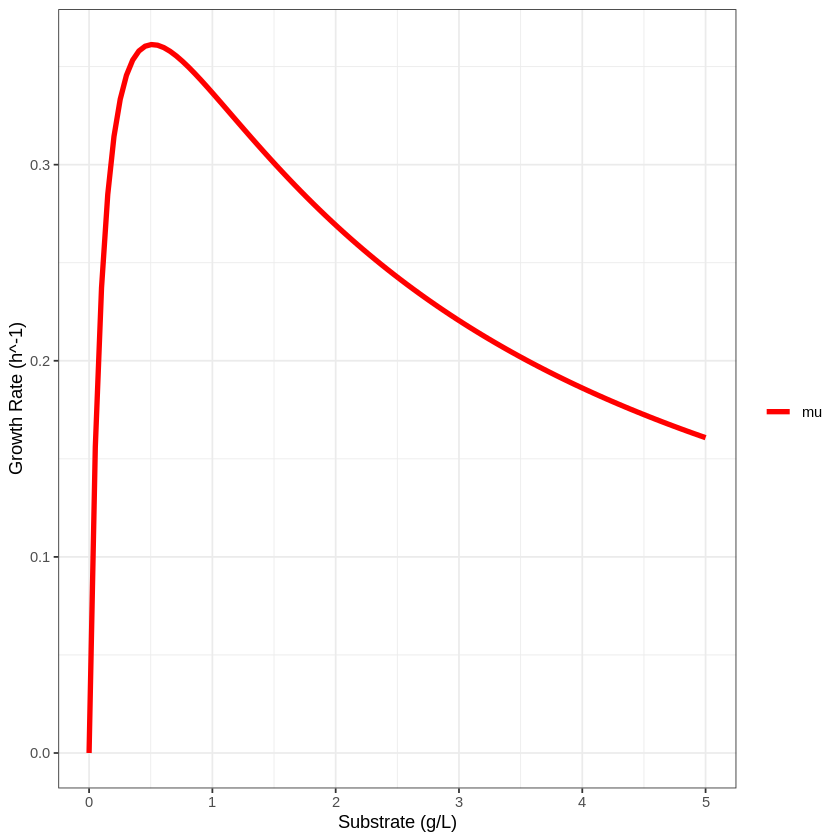

In [98]:
ggplot(data,aes(s)) +
  geom_line(aes(y=mu, color = "mu"), lwd = 1.5) +
  scale_color_manual("", breaks = c("mu"),
                          values = c("red")) +
  xlab("Substrate (g/L)") +
  ylab("Growth Rate (h^-1)") +
  theme_bw()

# Red para describir el proceso 

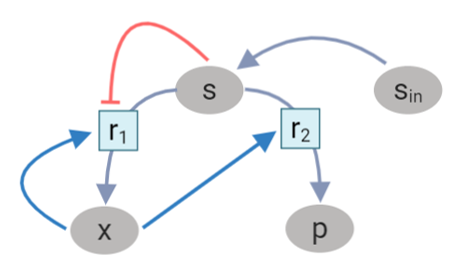

Figura 2. Red del proceso donde se observan las "reacciones" así como las especies que intervienen en estas reacciones y su efecto sobre las reacciones

En la Fig.2 se observa que para describir el presente proceso se consideran solamente dos reacciones, la reacción $r_1$ da lugar a la generación de biomasa a partir del sustrato, mientras que la reacción $r_2$ da lugar a la generación de producto a partir de sustrato. También se observa que la biomasa ($x$) tiene un efecto positivo sobre ambas reacciones mientras que el sustrato tiene un efecto negativo sobre la reacción $r_1$. Por otro lado es posible observar una entrada de sustrato $s_{in}$ al sistema. Esta entrada puede ser ajustada mediante la concentración de sustrato en la entrada y el flujo de alimentación. 


In [99]:
# establecer modelo 
model1 <- function(times, state, parms) {
        with(as.list(c(state,parms)), {
                
                # velocidad de crecimiento de biomasa
                rg = mu_max*s/(ks + s + ki*s^2)*x
                
                # velocidad de consumo de sustrato
                rs = (1/Yxs)*rg

                # velocidad de generación de producto
                rp = Ypx*rg
                
                # balance de material global 
                dVdt = Fin 
                
                # balance de materia para sustrato
                dsdt = Fin/V*(sf - s) - rs
                
                # balance de materia para biomasa
                dxdt = - Fin/V*x + rg

                # balance de materia para el producto
                dpdt = - Fin/V*p + rp
                
                return(list(c(dVdt, dsdt, dxdt, dpdt), Fin = Fin))
        })
}

A pesar que las ecuaciones para biomasa y sustrato son exactamente iguales que en el caso del reactor continuo, no se presenta un equilibrio porque el volumen siempre está aumentando

In [100]:
# establecer valor de parámetros 
p <- c(mu_max = 1.2, ks = 280, Yxs = 0.2, Ypx = 4, sf = 40, Fin = 0.5, ki = 0.6)

In [101]:
# condiciones iniciales
s <- c(V = 10.0, s = 10, x = 0.05, p = 0)

In [102]:
# timepo de integración 
times <- seq(0,100,len=100)

In [103]:
# resolver EDOs
out <- ode(y = s, times = times, func = model1, parms = p, method = "rk4")

In [104]:
# guardar resultados 
out <- as.data.frame(out)
head(out)

,time,V,s,x,p,Fin
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.000000,10.00000,10.00000,0.05000000,0.000000000,0.5
2,1.010101,10.50505,11.43355,0.04934680,0.007002576,0.5
3,2.020202,11.01010,12.73468,0.04893490,0.014088222,0.5
4,3.030303,11.51515,13.92089,0.04871734,0.021185158,0.5
5,4.040404,12.02020,15.00670,0.04865974,0.028252401,0.5
6,5.050505,12.52525,16.00430,0.04873659,0.035268957,0.5


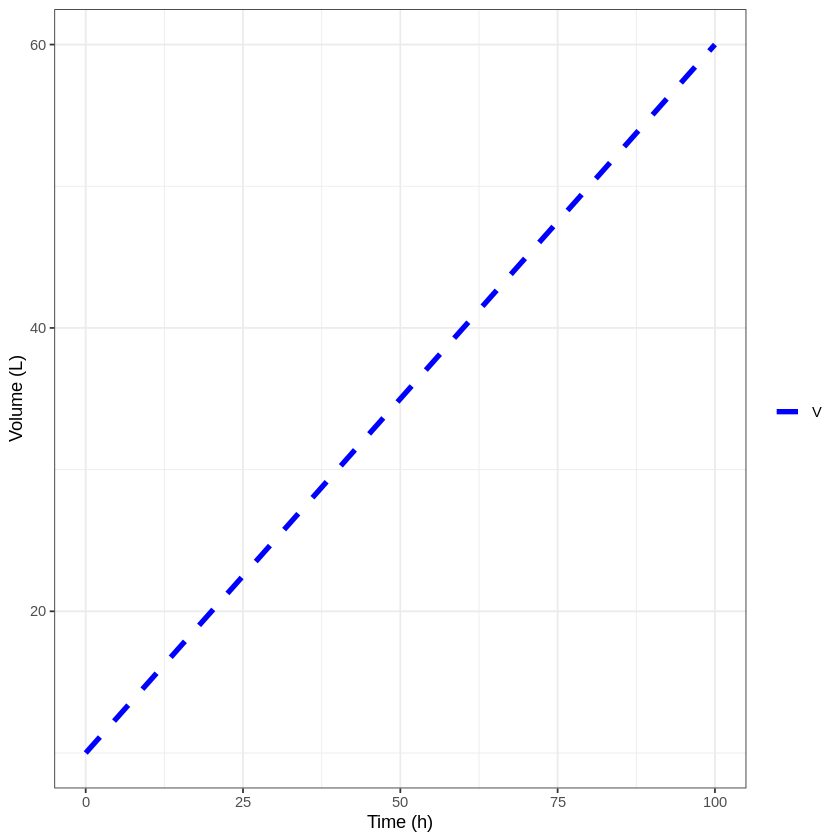

In [105]:
# mostrar resultados 
ggplot(out, aes(time)) +
        geom_line(aes(y = V, color = "V"),  lty = 2, lwd = 1.5) +
        scale_color_manual("", breaks = c("V"), values = c("blue")) +
        xlab("Time (h)") +
        ylab("Volume (L)") +
        theme_bw()

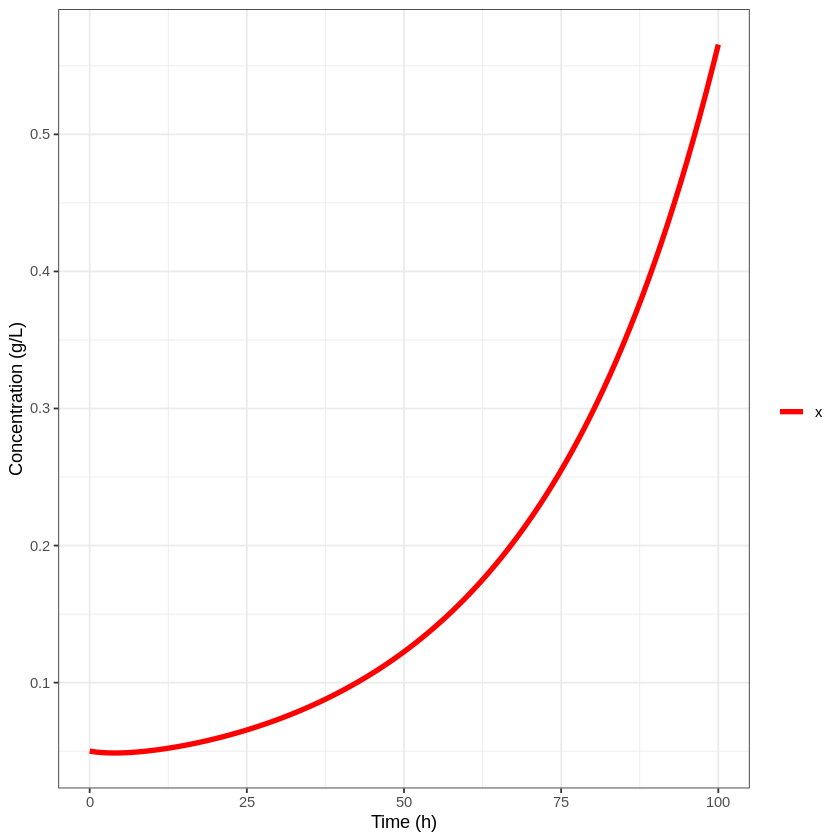

In [106]:
ggplot(out, aes(time)) +
        geom_line(aes(y = x, color = "x"),  lty = 1, lwd = 1.5) +
        scale_color_manual("", breaks = c("x"), values = c("red")) +
        xlab("Time (h)") +
        ylab("Concentration (g/L)") +
        theme_bw()

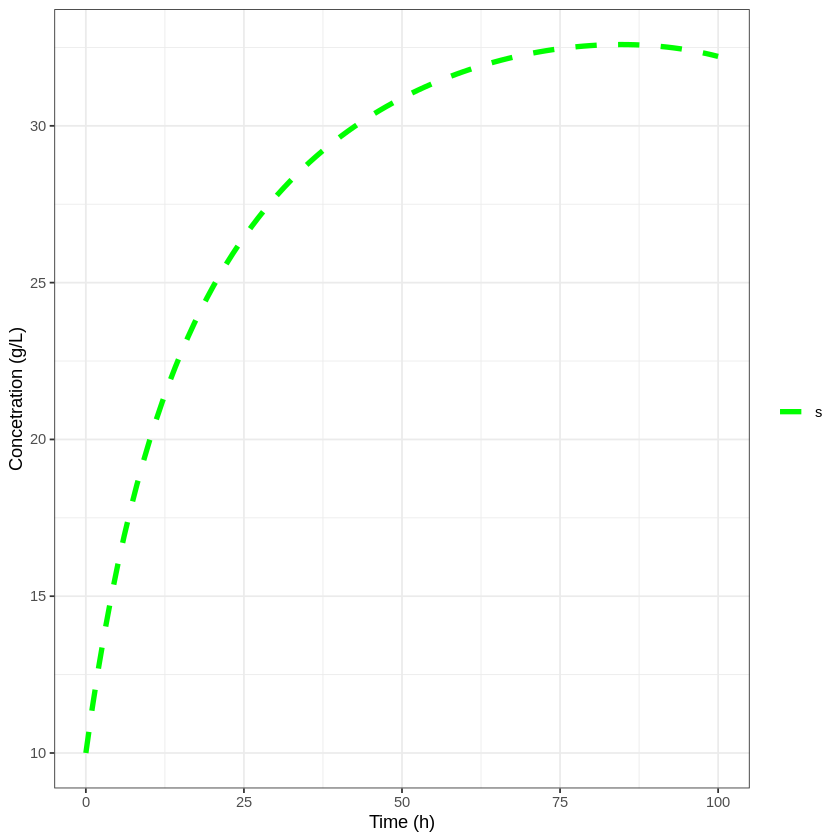

In [107]:
ggplot(out, aes(time)) +
        geom_line(aes(y = s, color = "s"),  lty = 2, lwd = 1.5) +
        scale_color_manual("", breaks = c("s"), values = c("green")) +
        xlab("Time (h)") +
        ylab("Concetration (g/L)") +
        theme_bw()

Para investigar el efecto de variar $F_{in}$ durante la fermentación, creamos una función que nos ayude a hacer esto 

In [108]:
# función para simular una fermentación con Fin variable 
change_input <- function(times, state, parms, Fin, model) {
        
        n <- length(times)
        # vectores para guardar los resultados  V0 = s[2]!
        V0 <- state[1]
        V <- rep(V0, n)
        s0 <- state[2]
        su <- rep(s0,n)
        x0 <- state[3]
        x <- rep(x0,n)
        p0 <- state[4]
        p <- rep(p0,n)
        # resolver EDO para los diferentes valores de Fin
        
        for (i in 1:(n-1)) {
                
                tspan <- c(times[i], times[i+1])
                
                parms["Fin"] <- Fin[i+1]
                
                # resolver EDOs
                out <- ode(y = state,
                           times = tspan,
                           func = model,
                           parms = parms,
                           method = "rk4")
                
                m <- nrow(out)
                
                # guardar resultados 
                V[i+1] <- out[m,2]
                su[i+1] <- out[m,3] 
                x[i+1] <- out[m,4] 
                p[i+1] <- out[m,5]
                # actualizar condiciones iniciales
                state <- out[m,c(2,3,4,5)]
                
        }
        
        return(list(times = times, V = V, su = su, x = x, p = p, Fin = Fin))
        
}

In [109]:
# entrada Fin
n <- length(times)
Fin <- rep(0, n)
Fin[50:75] <- 0.5
Fin[76:n] <- 0

In [110]:
# Resolver EDOs
out <- change_input(state = s, times = times, parms = p, Fin = Fin, model = model1)
out <- as.data.frame(out)

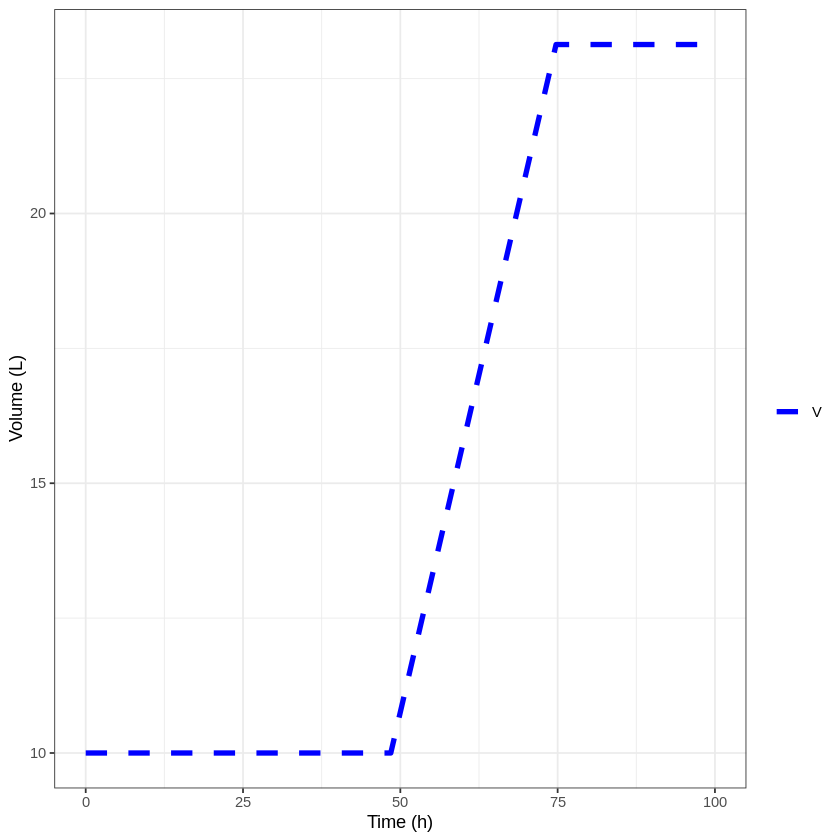

In [111]:
# mostrar resultados 
ggplot(out, aes(times)) +
        geom_line(aes(y=V, color = "V"), lty = 2, lwd = 1.5) +
        scale_color_manual("", breaks = c("V"), values = c("blue")) +
        xlab("Time (h)") +
        ylab("Volume (L)") +
        theme_bw()

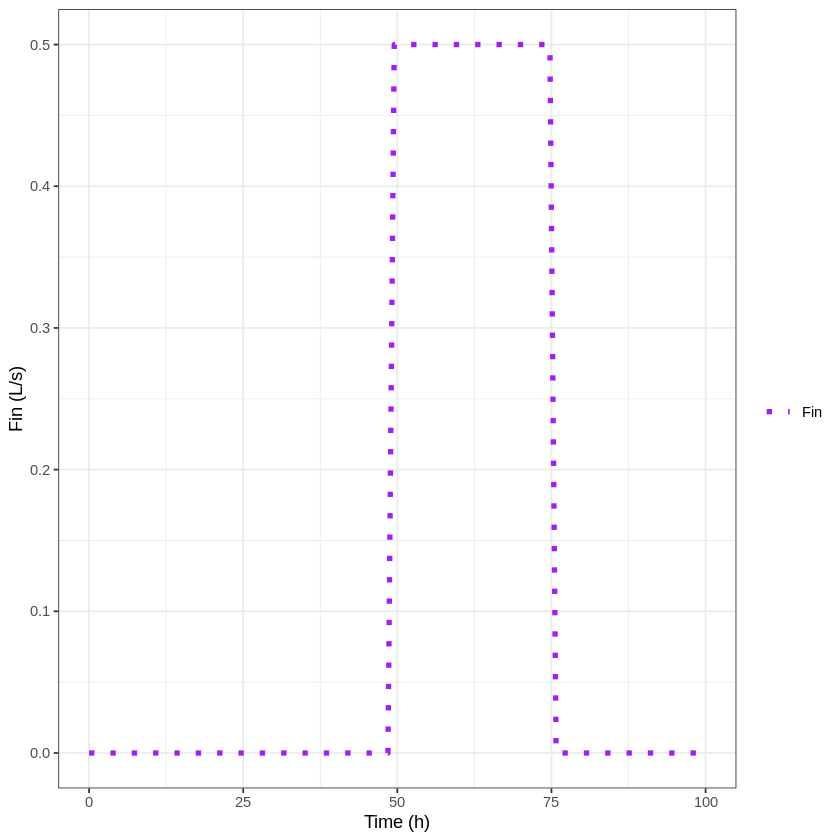

In [112]:
ggplot(out, aes(times)) +
        geom_line(aes(y=Fin, color = "Fin"), lty = 3, lwd = 1.5) +
        scale_color_manual("", breaks = c("Fin"), values = c("purple")) +
        xlab("Time (h)") +
        ylab("Fin (L/s)") +
        theme_bw()

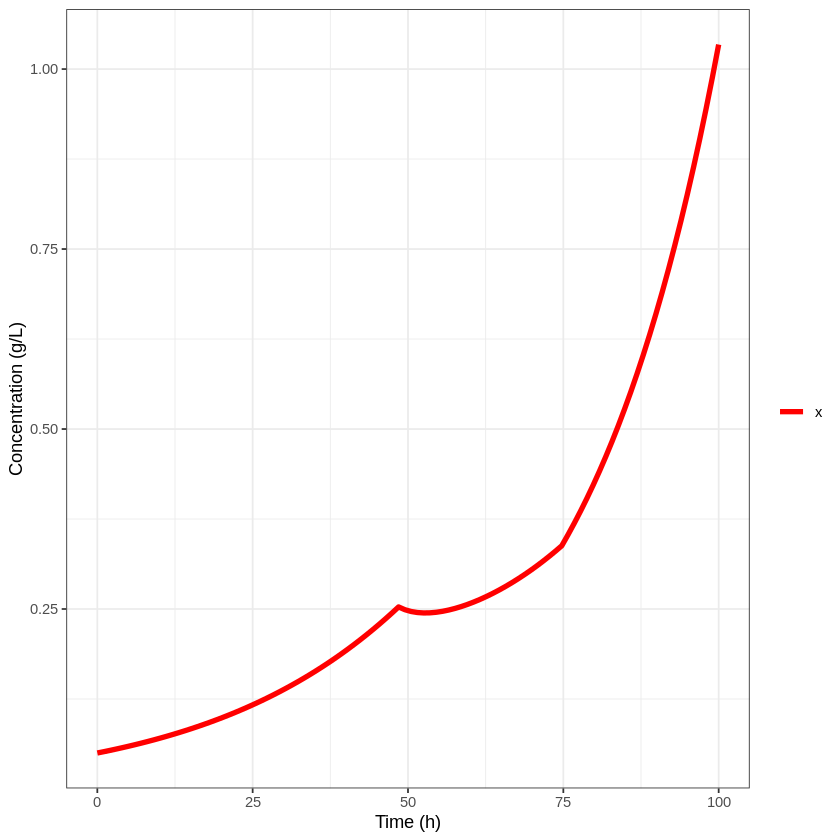

In [113]:
ggplot(out, aes(times)) +
        geom_line(aes(y=x, color = "x"), lty = 1, lwd = 1.5) +
        scale_color_manual("", breaks = c("x"), values = c("red")) +
        xlab("Time (h)") +
        ylab("Concentration (g/L)") +
        theme_bw()

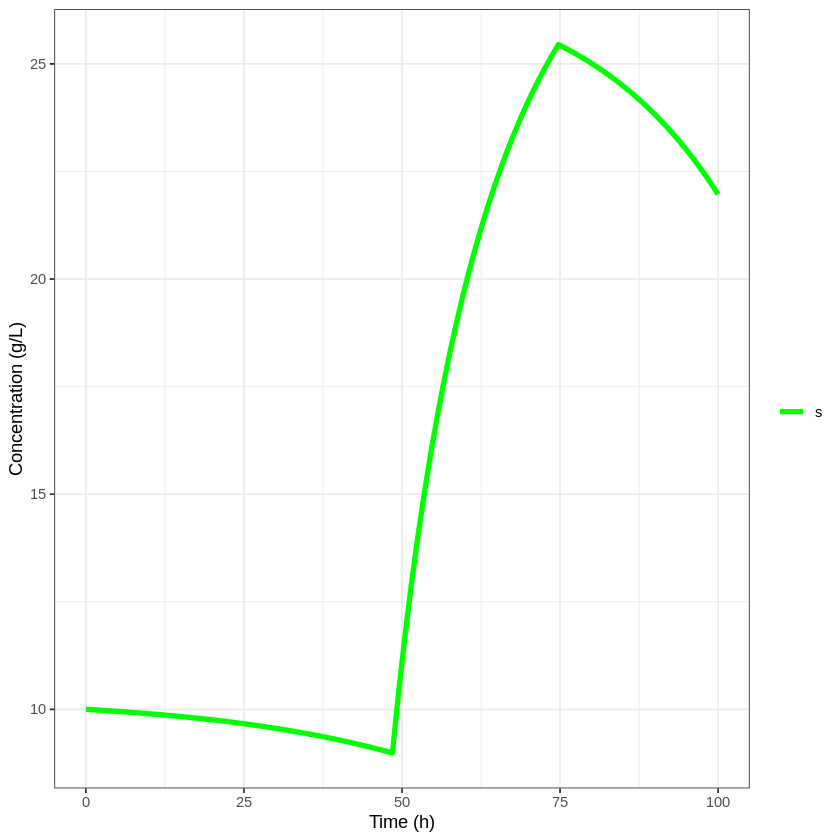

In [114]:
ggplot(out, aes(times)) +
        geom_line(aes(y=su, color = "s"), lty = 1, lwd = 1.5) +
        scale_color_manual("", breaks = c("s"), values = c("green")) +
        xlab("Time (h)") +
        ylab("Concentration (g/L)") +
        theme_bw()

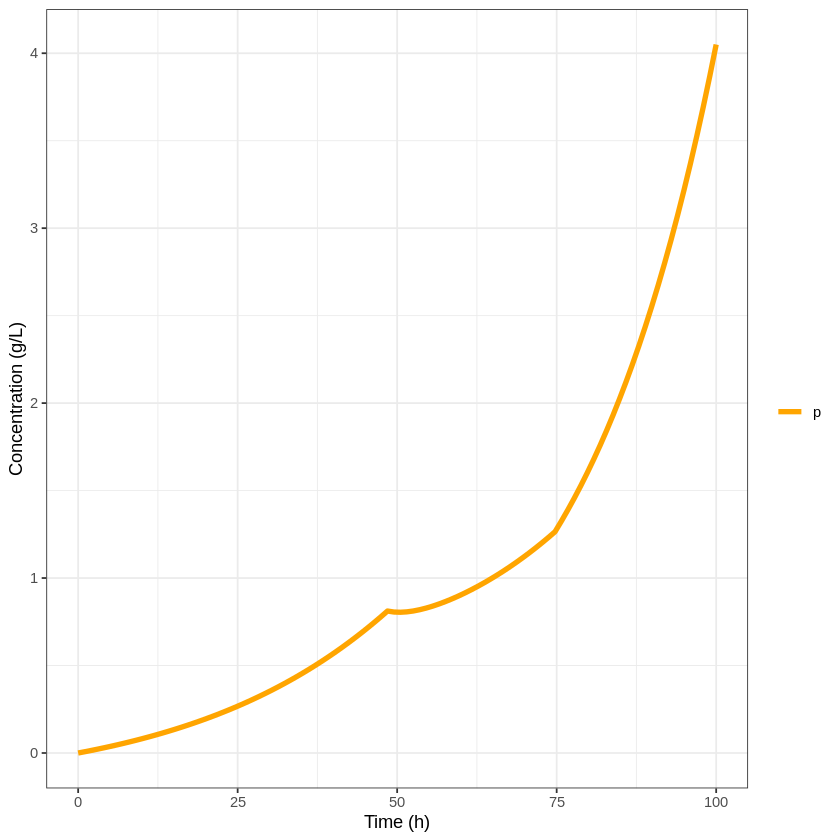

In [115]:
ggplot(out, aes(times)) +
        geom_line(aes(y=p, color = "p"), lty = 1, lwd = 1.5) +
        scale_color_manual("", breaks = c("p"), values = c("orange")) +
        xlab("Time (h)") +
        ylab("Concentration (g/L)") +
        theme_bw()

Con el objetivo de estudiar el efecto de $F_{in}$ en la concentración final de biomasa, creamos dos función que nos regresen la biomasa generada al final de la fermentación (`biomass1()`) y la biomasa final para diferentes valores de $F_{in}$ (`biomass2()`)

In [116]:
# función para obtener la masa final de biomasa (función a optimizar)
biomass1 <- function(times, state, parms, model) {
        
        out <- ode(y = state, times = times, func = model, parms = parms, method = "rk4")
        m <- nrow(out)
        
        ms_end <- out[m,2]*out[m,3]
        mx_end <- out[m,2]*out[m,4]
        mp_end <- out[m,2]*out[m,5]
        V_end <- out[m,2]
        s_end <- out[m,3]
        x_end <- out[m,4]
        p_end <- out[m,5]
        return(list(ms_end = ms_end, mx_end = mx_end, mp_end = mp_end, V_end = V_end, s_end = s_end, x_end = x_end, p_end = p_end))
}

In [117]:
# función para obtener la biomasa final para diferentes valores de Fin 
biomass2 <- function(times, state, parms, Fin, model) {
        
        n <- length(Fin)
        ms_end <- numeric(length = n)
        mx_end <- numeric(length = n)
        mp_end <- numeric(length = n)
        V_end <- numeric(length = n)
        s_end <- numeric(length = n)
        x_end <- numeric(length = n)
        p_end <- numeric(length = n)
        for (i in 1:n) {
                
                parms["Fin"] <- Fin[i]
                
                out <- biomass1(times = times,state = state,parms = parms, model = model)
                
                ms_end[i] <- out$ms_end
                mx_end[i] <- out$mx_end
                mp_end[i] <- out$mp_end
                V_end[i] <- out$V_end
                s_end[i] <- out$s_end
                x_end[i] <- out$x_end
                p_end[i] <- out$p_end
        }
        
        return(list(ms_end = ms_end, mx_end = mx_end, mp_end = mp_end, V_end = V_end, s_end = s_end, x_end = x_end, p_end = p_end))
}

Ahora podemos investigar si hay un valor de $F_{in}$ que permita obtener una máxima producción de biomasa

In [118]:
# valores de Fin a investigar 
Fin <- seq(0, 2, len = 100)

In [119]:
# obtener la biomasa al terminar la fermentación para cada valor de Fin 
out <- biomass2(times = times, state = s, parms = p, Fin = Fin, model = model1)

In [120]:
# guardar resultados 
out <- data.frame(Fin = Fin, ms_end = out$ms_end, mx_end = out$mx_end, mp_end = out$mp_end,
                  V_end = out$V_end, s_end = out$s_end, x_end = out$x_end, p_end = out$p_end)

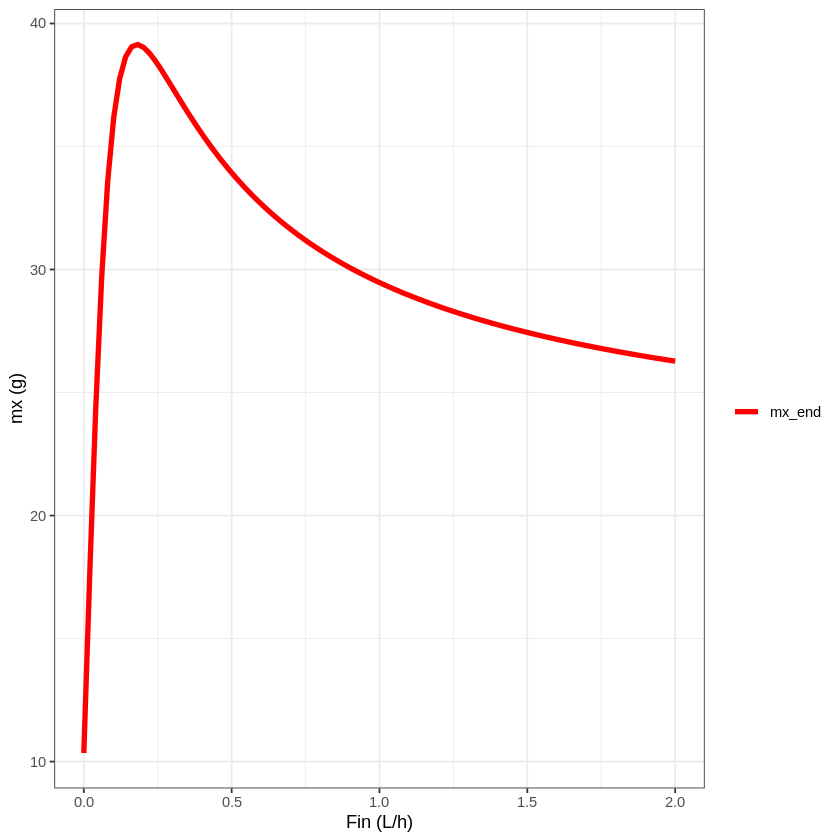

In [121]:
# mostrar resultados
ggplot(out, aes(Fin)) +
        geom_line(aes(y=mx_end, color = "mx_end"), lty = 1, lwd = 1.5) +
        scale_color_manual("", breaks = c("mx_end"), values = c("red")) +
        xlab("Fin (L/h)") +
        ylab("mx (g)") +
        theme_bw()

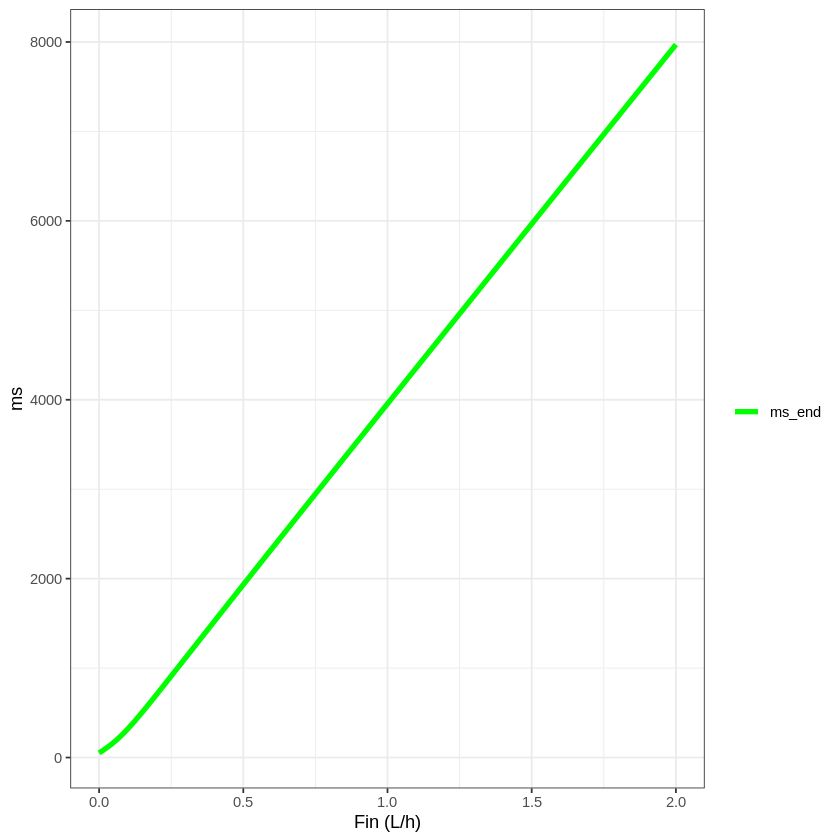

In [122]:
ggplot(out, aes(Fin)) +
        geom_line(aes(y=ms_end, color = "ms_end"), lty = 1, lwd = 1.5) +
        scale_color_manual("", breaks = c("ms_end"), values = c("green")) +
        xlab("Fin (L/h)") +
        ylab("ms") +
        theme_bw()

¿Cómo influye el efecto de inhibición ($k_i$) sobre la producción de biomasa?

In [123]:
# valores de Fin a evaluar
Fin <- seq(0, 3, len=100)
# valores de ki a evaluar
ki <- c(0.3,0.35,0.4,0.45,0.5,0.6)
# matriz para guardar los resultados 
out <- matrix(nrow = length(ki) + 1, ncol = length(Fin))
out[1,] <- Fin

In [124]:
# obtener la biomasa generada para los diferentes valores de Fin y ki 
p["sf"] <- 50
j <- 2
for (i in ki) {
        
        p["ki"] <- i
        out1 <- biomass2(times = times, state = s, parms = p, Fin = Fin, model = model1)
        out[j,] <- out1$mx_end
        j <- j + 1
}
p["sf"] <- 40

In [125]:
# preparar los resultados para mostrarlos 
out <- t(out)
out <- as.data.frame(out)
colnames(out) <- c("Fin", paste0("ki",seq(1,6)))
head(out)

,Fin,ki1,ki2,ki3,ki4,ki5,ki6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00000000,11.75005,11.51340,11.27742,11.04249,10.80900,10.34775
2,0.03030303,33.55905,32.18620,30.74403,29.25057,27.72687,24.67872
3,0.06060606,58.53274,55.01212,51.07259,46.85689,42.55258,34.39806
4,0.09090909,83.35281,76.52568,68.55975,60.10597,51.91585,38.18340
5,0.12121212,106.87687,95.26774,81.70825,68.14349,56.14863,38.47565
6,0.15151515,128.51457,110.46375,90.28496,71.88650,57.10060,37.36573


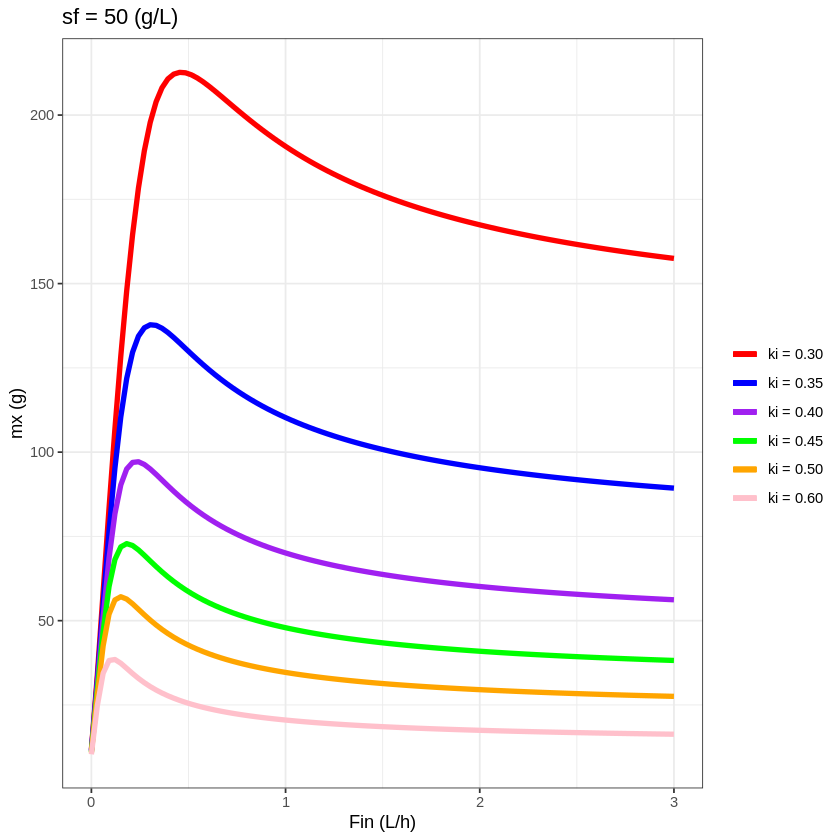

In [126]:
# mostrar resultados 
ggplot(out, aes(Fin)) +
        geom_line(aes(y = ki1, color = "ki = 0.30"), lwd = 1.5) +
        geom_line(aes(y = ki2, color = "ki = 0.35"), lwd = 1.5) +
        geom_line(aes(y = ki3, color = "ki = 0.40"), lwd = 1.5) +
        geom_line(aes(y = ki4, color = "ki = 0.45"), lwd = 1.5) +
        geom_line(aes(y = ki5, color = "ki = 0.50"), lwd = 1.5) +
        geom_line(aes(y = ki6, color = "ki = 0.60"), lwd = 1.5) +
        scale_color_manual("", breaks = c("ki = 0.30", "ki = 0.35", "ki = 0.40", 
                                          "ki = 0.45", "ki = 0.50", "ki = 0.60"),
                           values = c("red", "blue", "purple", "green", "orange", "pink")) + 
        xlab("Fin (L/h)") +
        ylab("mx (g)") + 
        labs(title = "sf = 50 (g/L)") +
        theme_bw()

Si además de cambiar el valor de $ki$ queremos cambiar el valor de $s_f$, es conveniente crear una fucnión

In [127]:
# función para obtener la biomasa final para diferentes valores de Fin y ki
biomass3 <- function(times, state, parms, Fin, ki, model) {
        
        n <- length(ki)
        
        # lista para guardar los vectores que regresa biomass2()
        mx_end <- list(length = n)
        
        for (i in 1:n) {
                
                parms["ki"] <- ki[i]
                
                out <- biomass2(times = times,state = state,parms = parms,Fin = Fin, model = model)
                
                mx_end[[i]] <- out$mx_end # <- esto es un vector
                
        }
        
        return(mx_end)
}

Ahora podemos estudiar que efecto tiene variar el valor de $s_f$ en la alimentación

In [128]:
# valores de Fin a estudiar
Fin <- seq(0, 3, len = 100)
# valores de ki a evaluar
ki <- c(0.3, 0.35, 0.4, 0.45, 0.5, 0.6)
# valores de sf a estudiar 
sf <- seq(0, 50, 10)

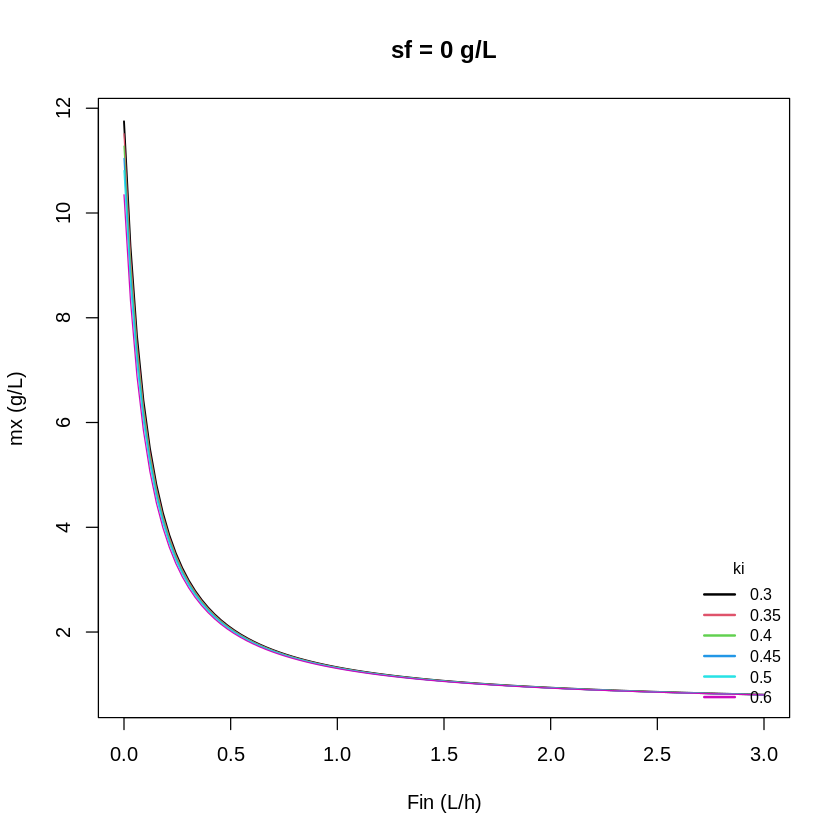

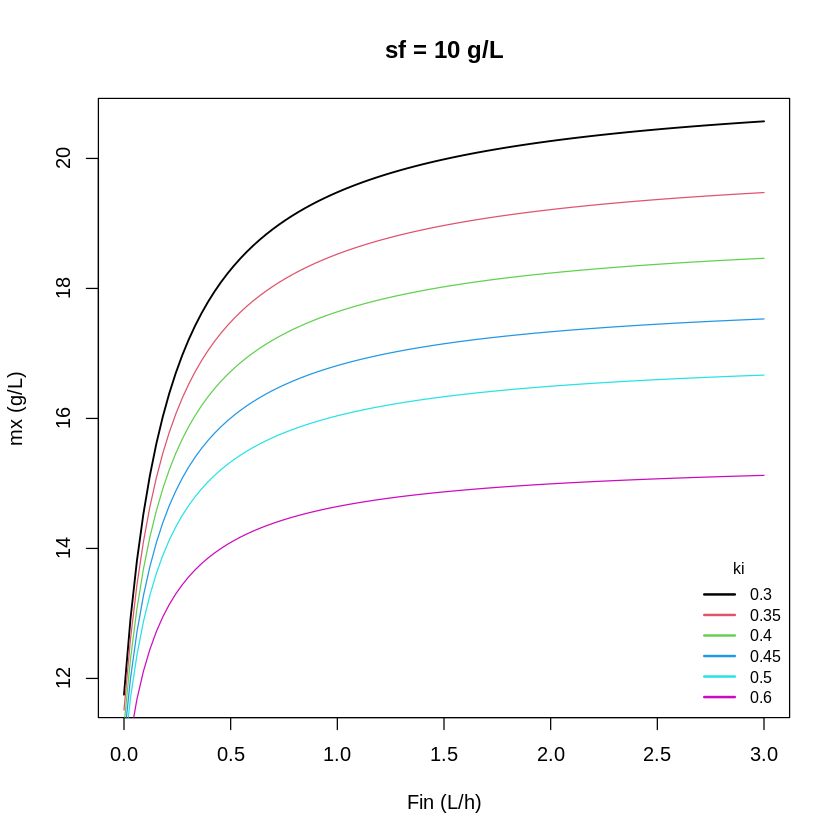

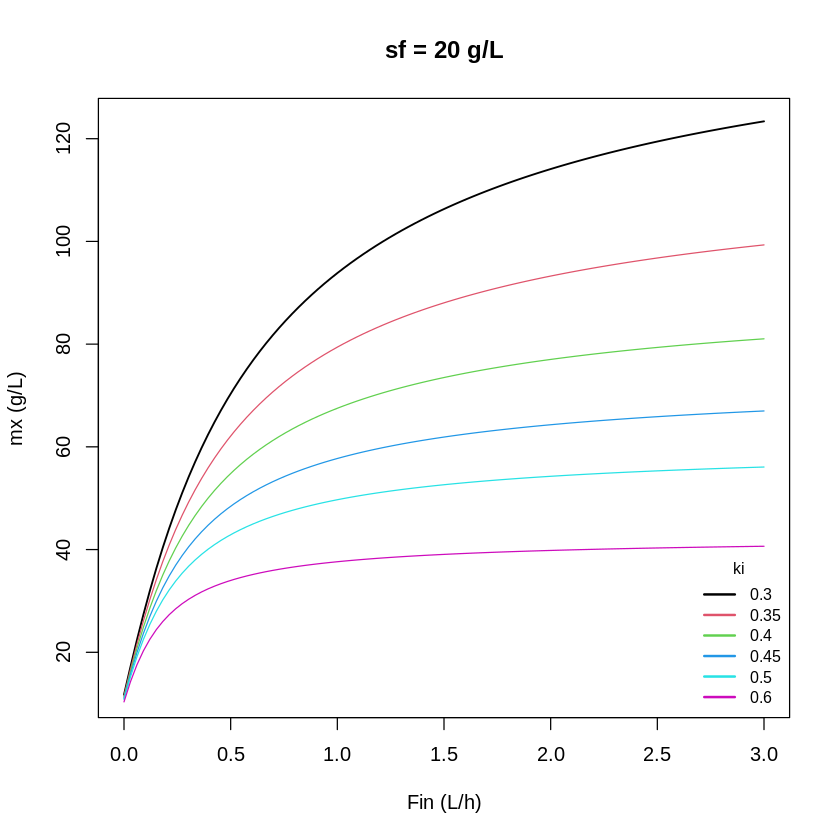

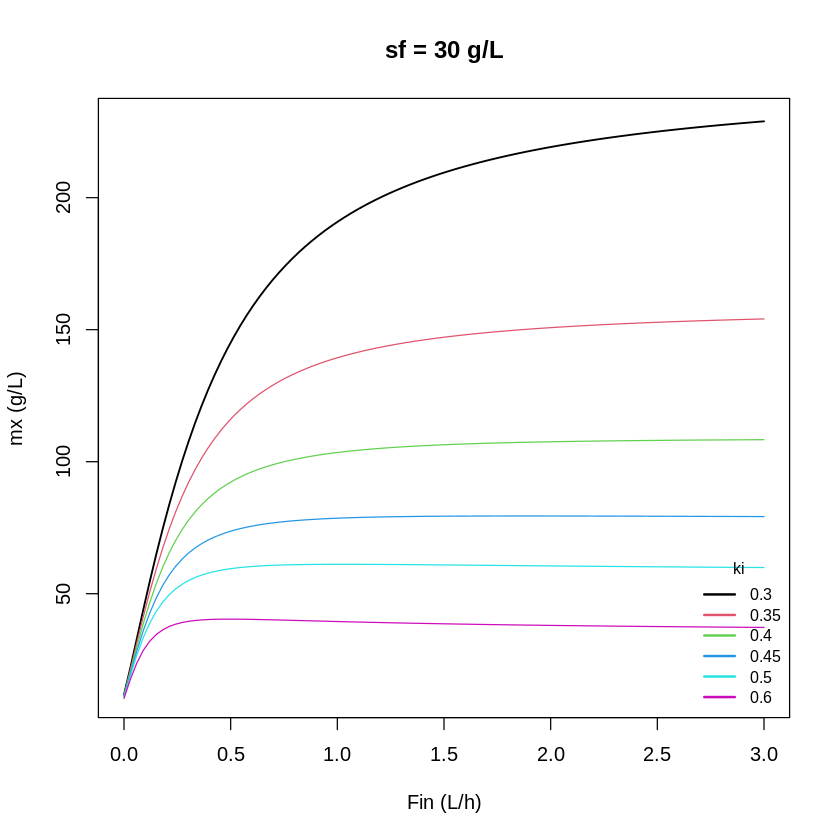

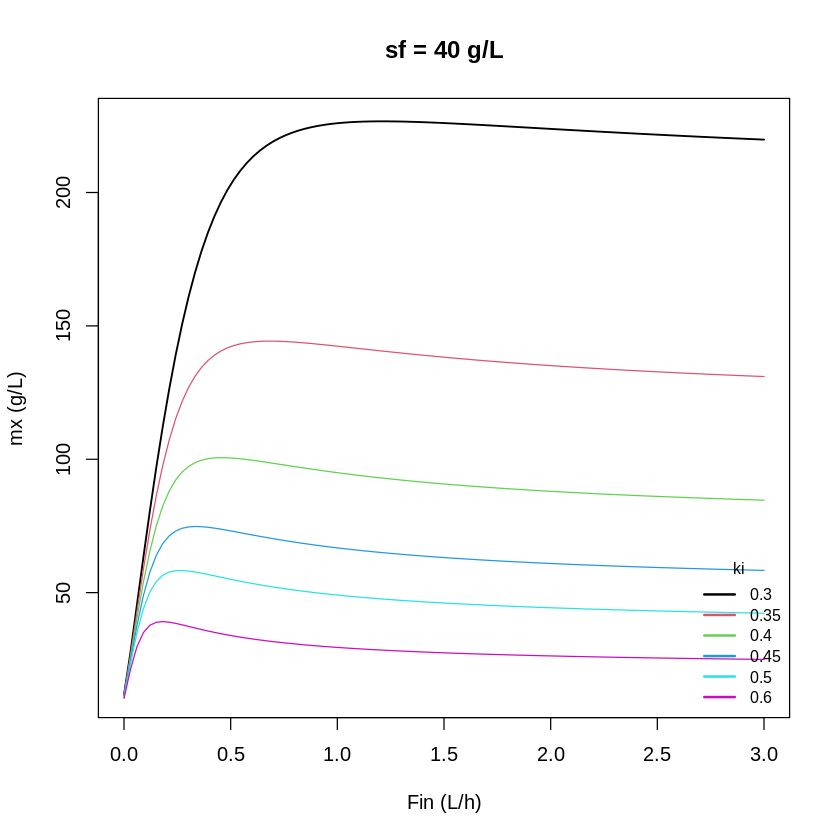

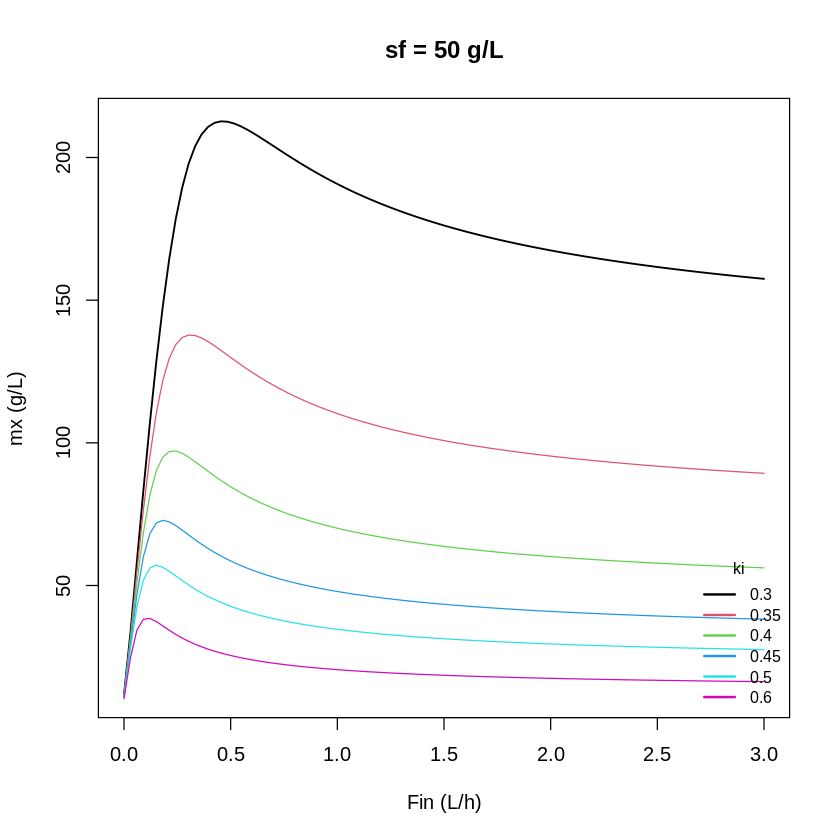

In [129]:
for (i in sf) {
        
        p["sf"] <- i
        
        out <- biomass3(times = times, state = s, parms = p, Fin = Fin, ki = ki, model = model1)
        
        for (j in 1:length(out)) {
                
                if (j == 1) {
                        
                        plot(Fin, out[[j]], ylab = "mx (g/L)", xlab = "Fin (L/h)" ,
                             main = paste0("sf = ", i, " g/L"), lwd = 1.5,
                        type = "l", col = j)
                }
                
                else {
                        lines(Fin, out[[j]], type = "l", col = j)
                }
                
                if (j == length(out)) {
                        
                        legend("bottomright", legend = ki, col = seq(1,length(ki)), bty = "n", lty = 1, 
                               cex = 0.8, title = "ki", lwd = 2)
                }
        }
        
}

Para hacer cada grafica se realizan 600 simulaciones 

Vemos en la gráfica anterior que cuando $ki = 0.3$, y $s_f = 50$ se presenta un máximo en la cantidad de biomasa generada en un valor de $Fin \approx 0.5$. ¿Podemos determinar este valor exactamente?

In [130]:
# valores de los parámetros para la optimización de Fin
Fin <- seq(0, 2, len = 100)
ki <- 0.3
p["ki"] <- ki
sf = 50
p["sf"] <- sf

In [131]:
# obtener biomasa final 
out <- biomass3(times = times, state = s, parms = p, Fin = Fin, ki = ki, model = model1)

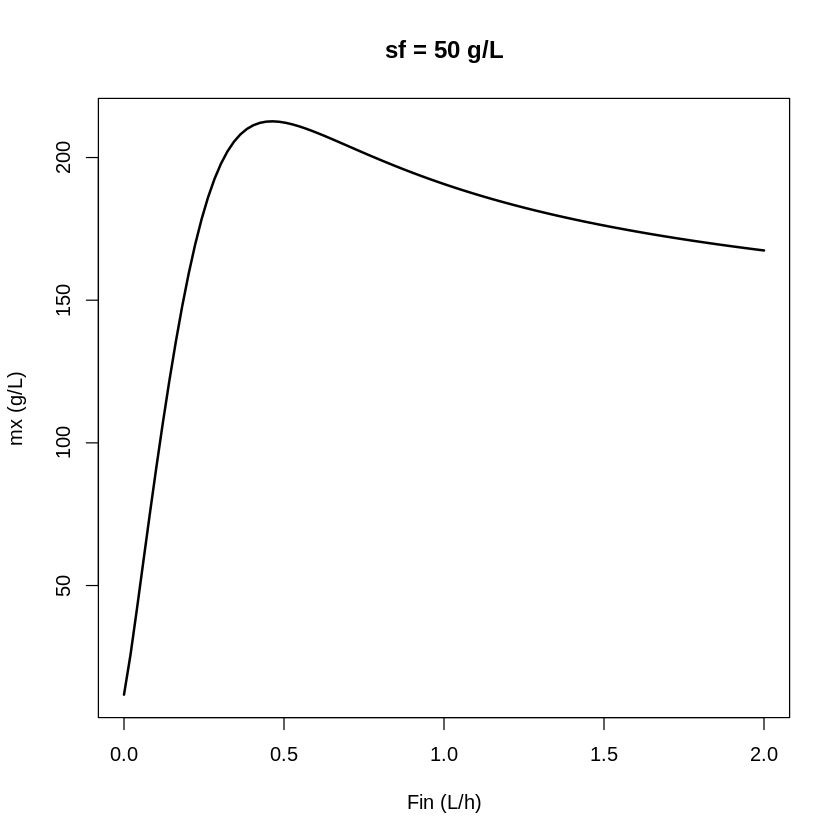

In [132]:
# mostrar grafica
plot(Fin, out[[1]], ylab = "mx (g/L)", xlab = "Fin (L/h)", main = paste0("sf = ", sf, " g/L"),
     type = "l", col = 1, lwd = 2)

# Optimización 

### Encontrar el valor de $F_{in}$, que si mantenemos durante toda la fermentación, genera la máxima producción de biomasa

Para realizar las siguiente optimizaciones hacemos uso de algoritmos genéticos. Por esta  razón es conveniente explicar la terminología empleada con estos algoritmos

* Una solución candidata se denomina individuo. Una población denota un grupo de individuos.

* El genotipo o cromosoma denota la representación de la estructura de datos individuales.

* Un gen es una posición de valor en tal representación y un alelo es un valor particular para un gen.

* La función de evaluación se conoce como fitness y el fenotipo representa cómo opera el individuo durante la evaluación de la función fitness.

* La creación de nuevas soluciones se denomina cría y se produce debido a la aplicación de operadores genéticos, como el cruce y la mutación.

* Crossover implica la selección de soluciones de dos padres para generar hijos. La mutación realiza un ligero cambio en un individuo.


In [133]:
# definir la función a maximizar 
fitness1 <- function(x, times, state, parms, model) {
        
        parms["Fin"] <- x
        
        out <- biomass1(times = times, state = state, parms = parms, model = model)
        
        return(out$mx_end)
}

In [134]:
# evaluar la función 
fitness1(x = 1, times = times, state = s, parms = p, model = model1)

V 
190.711

In [135]:
# optimizar para encontrar Fin 
GA <- ga(type = "real-valued",
         fitness = fitness1,
         times= times,
         state = s,
         parms = p,
         model = model1,
         lower = 0,
         upper = 2,
         maxiter = 10,
         maxFitness = 1e6)

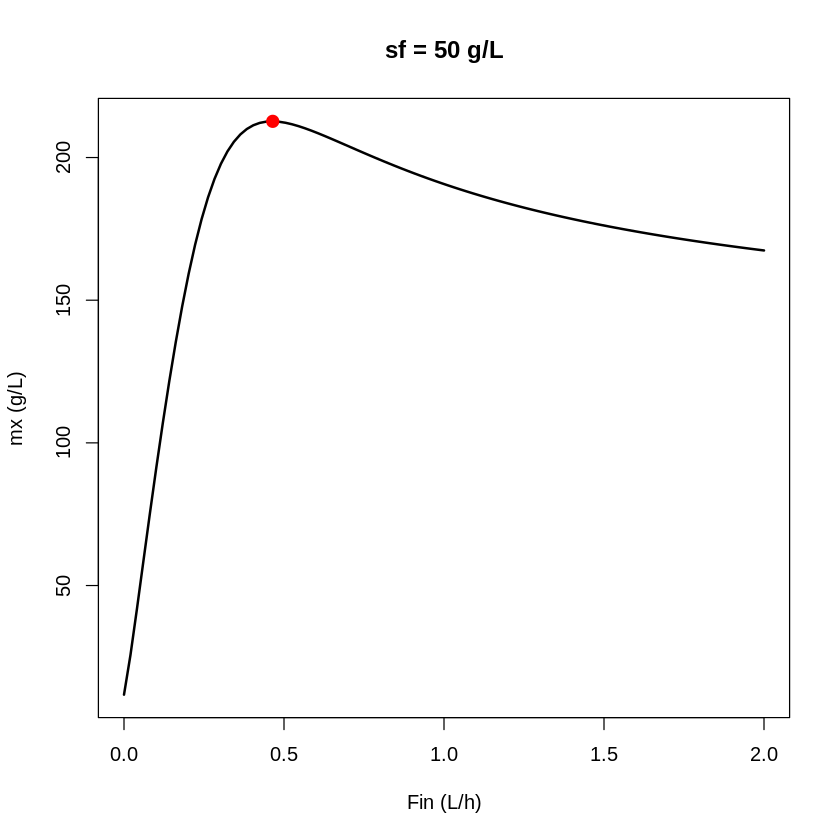

In [136]:
# mostrar grafica
plot(Fin, out[[1]], ylab = "mx (g/L)", xlab = "Fin (L/h)", main = paste0("sf = ", sf, " g/L"),
     type = "l", col = 1, lwd = 2)
points(GA@solution, GA@fitnessValue, col="red", pch = 20, cex = 2)

In [137]:
cat("Fin_opt:", GA@solution," L/h" ,"\n")
cat("mx_opt:", GA@fitnessValue, "g")

Fin_opt: 0.4648021  L/h 
mx_opt: 212.6854 g

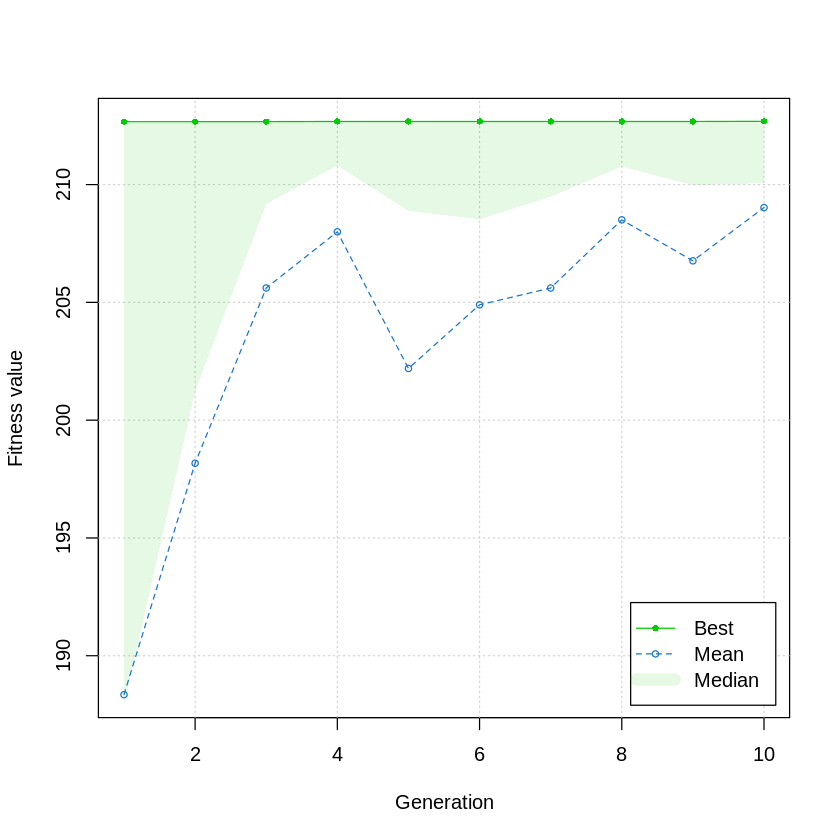

In [138]:
# evolución del GA
plot(GA)

### Encontrar el perfil de alimentación $F_{in}$ que genera la máxima producción de biomasa

Pese a que lo anterior genera un buen resultado, no es una buena idea alimentar un flujo constante de sustrato al biorreactor. Los microorganismo experimentan diferentes fases de crecimiento, y en cada una de estas fases requieren diferentes cantidades de sustrato. Por lo anterior es evidente que una mejor estrategia de optimización es variar el flujo de alimentación ($F_{in}$) de acuerdo a las necesidades del microorganismo. 

In [139]:
# función para variar el flujo de alimentación al biorreactor y obtener la biomasa generada al final de la fermentación
fitness2 <- function(x, times, state, parms, model) {
        
        Fin <- rep(x, each = 10)
        
        out <- change_input(times = times, state = s, parms = p, Fin = Fin, model = model1)
        n <- length(out$V)
        
        mx_end <- out$x[n]*out$V[n]
        
        return(mx_end)
}

In [140]:
# optimizar para encontrar el perfil de Fin que genera la máxima cantidad de biomasa
GA1 <- ga(type = "real-valued",
         fitness = fitness2,
         times= times,
         state = s,
         parms = p,
         model = model1,
         lower = rep(0, 10),
         upper = rep(2, 10),
         maxiter = 100, 
         popSize = 50)

In [141]:
cat("mx_opt: ", GA1@fitnessValue, "g/L")

mx_opt:  234.167 g/L

In [142]:
Fin_plot <- rep(GA1@solution, each = 10)

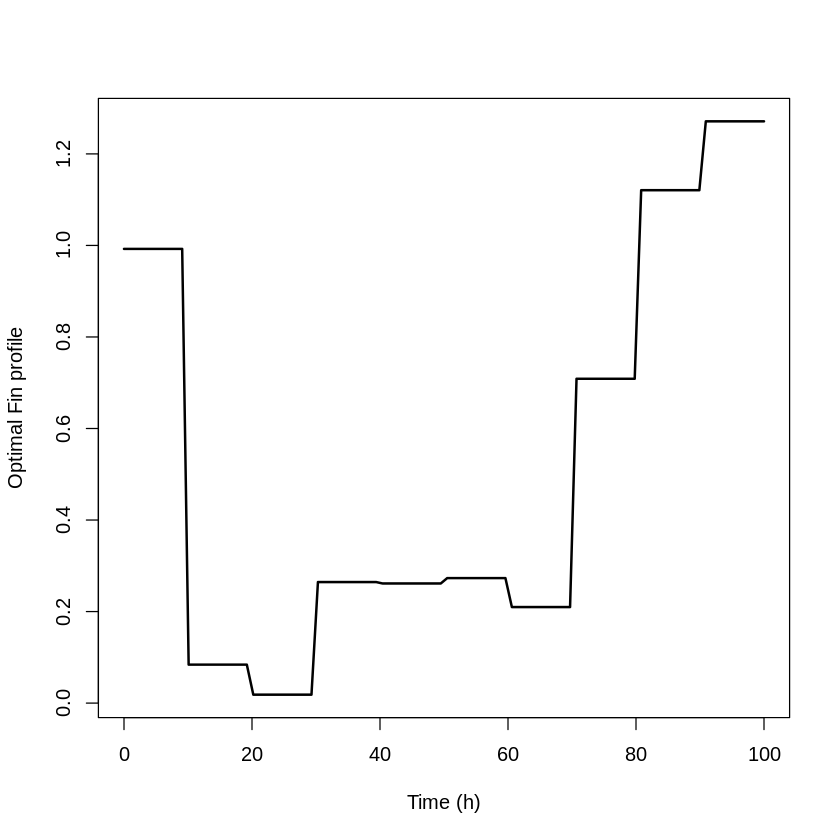

In [143]:
plot(times, Fin_plot, type = "l", lwd = 2, ylab = "Optimal Fin profile", xlab = "Time (h)")

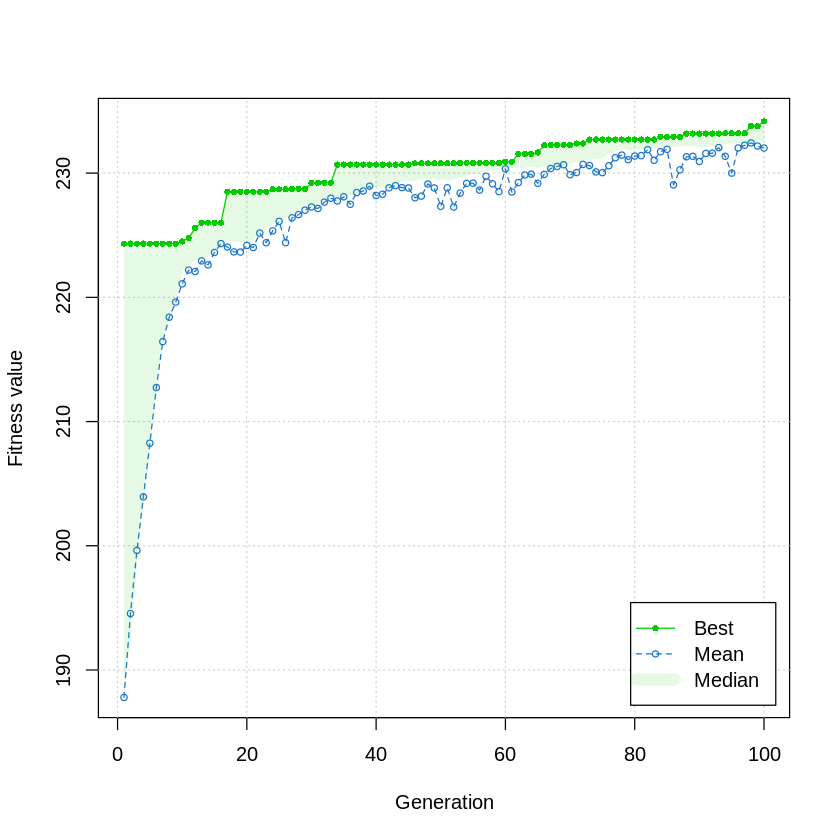

In [144]:
plot(GA1)

Vemos que con un perfil de $F_{in}$ obtenemos un mayor valor de $m_{x,opt}$ que si usamos un solo valor de $F_{in}$, aunque esto requiere un mayor coste computacional. 

In [145]:
# simular con el resultado de la simulación
out <- change_input(state = s, times = times, parms = p, Fin = Fin_plot, model = model1)
data_opt <- data.frame(times = out$times, V = out$V, s = out$su, x = out$x, p = out$p, Fin = out$Fin)

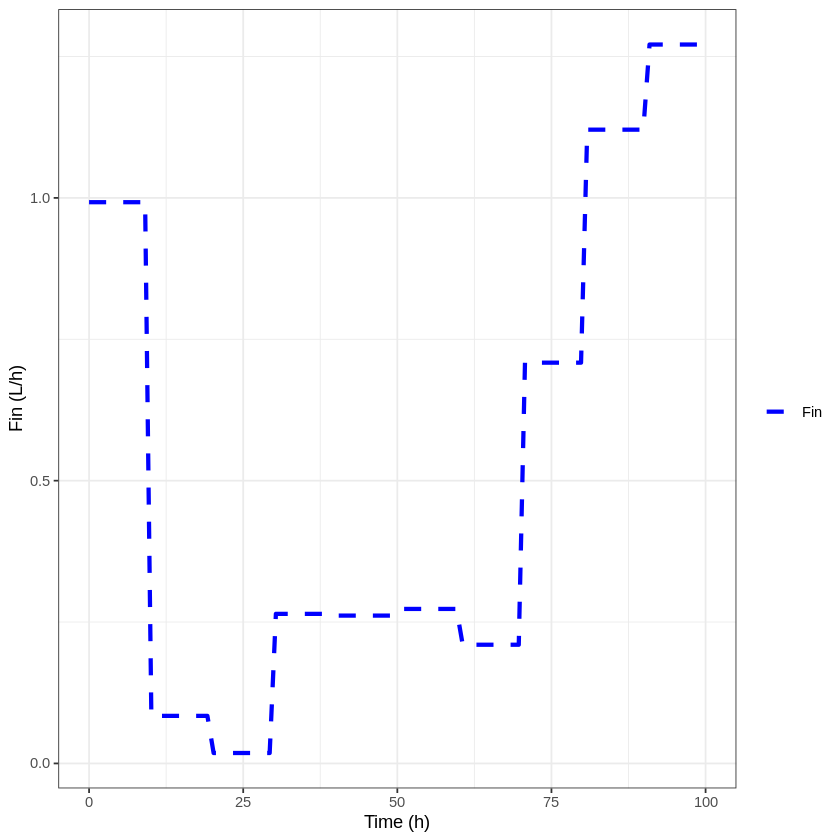

In [146]:
# mostrar resultados 
ggplot(data_opt, aes(times)) +
        geom_line(aes(y = Fin, color = "Fin"), lty = 2, lwd = 1.2) +
        scale_color_manual("", breaks = c("Fin"), values = c("blue")) +
        xlab("Time (h)") +
        ylab("Fin (L/h)") +
        theme_bw()

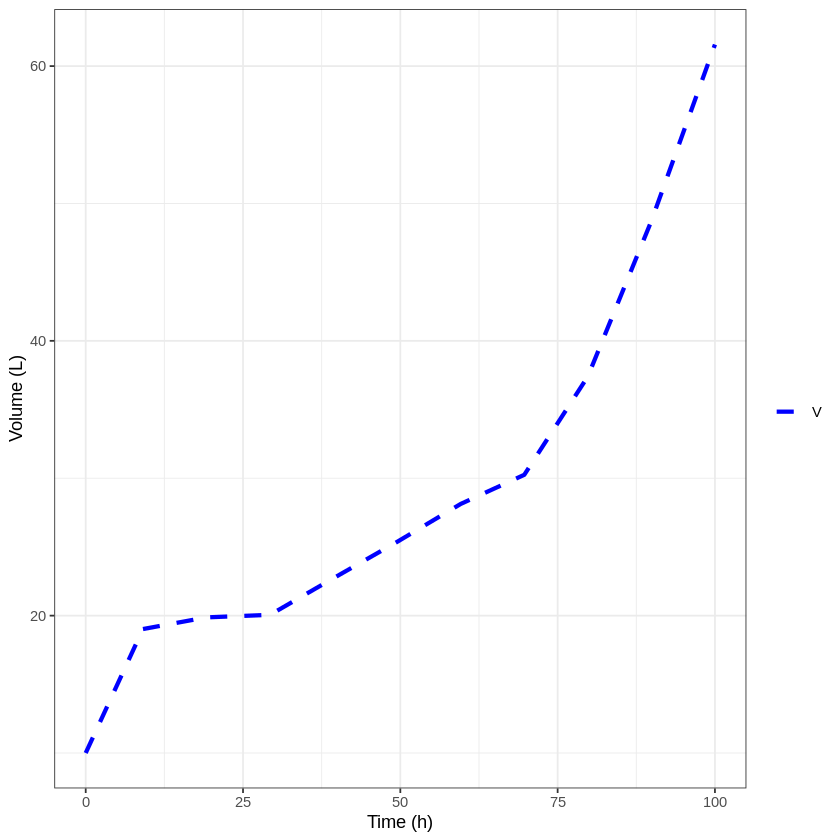

In [147]:

ggplot(data_opt, aes(times)) +
        geom_line(aes(y=V, color = "V"), lty = 2, lwd = 1.2) +
        scale_color_manual("", breaks = c("V"), values = c("blue")) +
        xlab("Time (h)") +
        ylab("Volume (L)") +
        theme_bw()

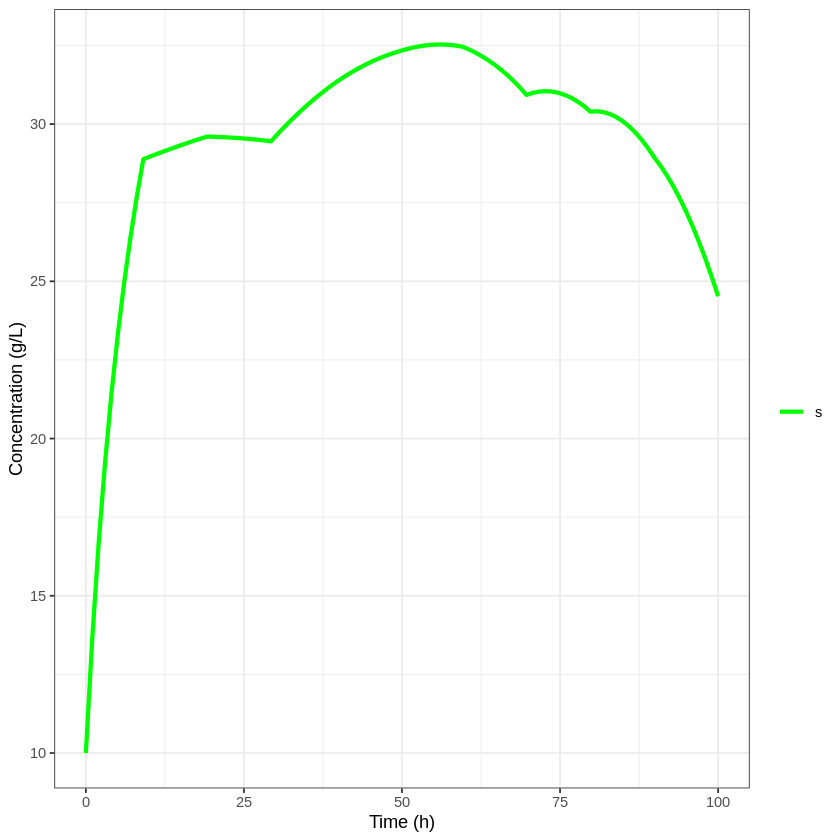

In [148]:
ggplot(data_opt, aes(times)) +
        geom_line(aes(y=s, color = "s"), lty = 1, lwd = 1.2) +
        scale_color_manual("", breaks = c("s"), values = c("green")) +
        xlab("Time (h)") +
        ylab("Concentration (g/L)") +
        theme_bw()

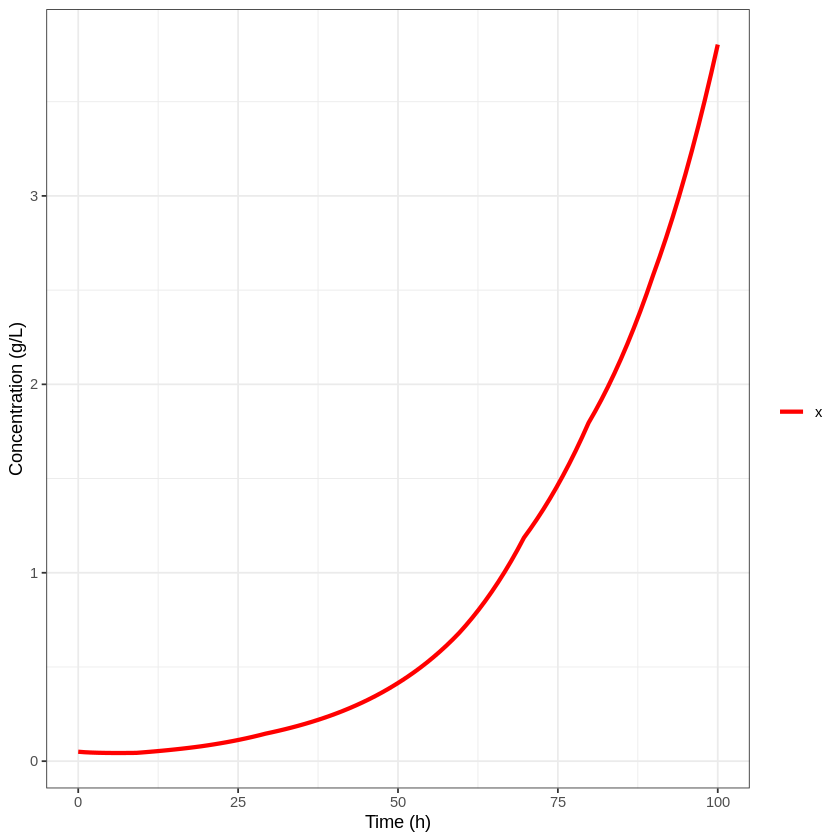

In [149]:
ggplot(data_opt, aes(times)) +
        geom_line(aes(y=x, color = "x"), lty = 1, lwd = 1.2) +
        scale_color_manual("", breaks = c("x"), values = c("red")) +
        xlab("Time (h)") +
        ylab("Concentration (g/L)") +
        theme_bw()

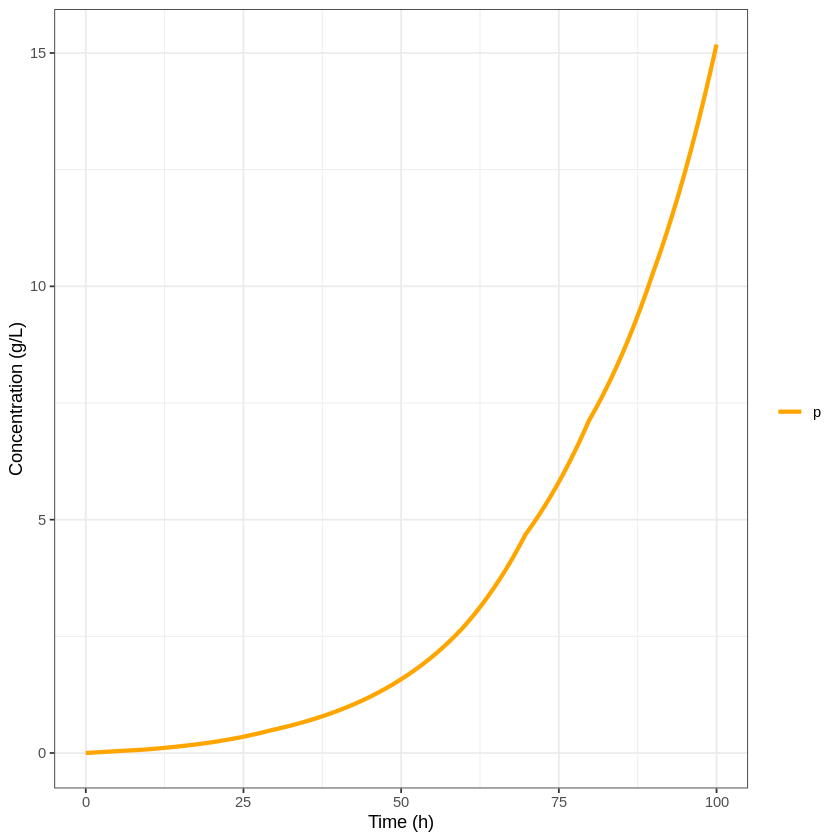

In [150]:
ggplot(data_opt, aes(times)) +
        geom_line(aes(y=p, color = "p"), lty = 1, lwd = 1.2) +
        scale_color_manual("", breaks = c("p"), values = c("orange")) +
        xlab("Time (h)") +
        ylab("Concentration (g/L)") +
        theme_bw()

In [151]:
# verificar valor máximo de biomasa
n <- length(times)
cat("mx_end:",data_opt$V[n]*data_opt$x[n], "g")

mx_end: 234.167 g

Para mostrar la diferencia entre un flujo de alimentación $F_{in}$ optimizado y uno que no lo está, podemos usar el valor promedio de $F_{in}$ en la optimización y comparar ambas simulaciones 

In [152]:
# Fin promedio en la optimización
Fin_avg <- mean(data_opt$Fin)

In [153]:
# realizar simulación con Fin_avg
n <- length(times)
Fin <- rep(Fin_avg, n)
out <- change_input(state = s, times = times, parms = p, Fin = Fin, model = model1)

In [154]:
# guardar resultados  
data_no_opt <- data.frame(times = out$times, V = out$V, s = out$su, x = out$x, p = out$p, Fin = out$Fin)

Realizar comparaciones 

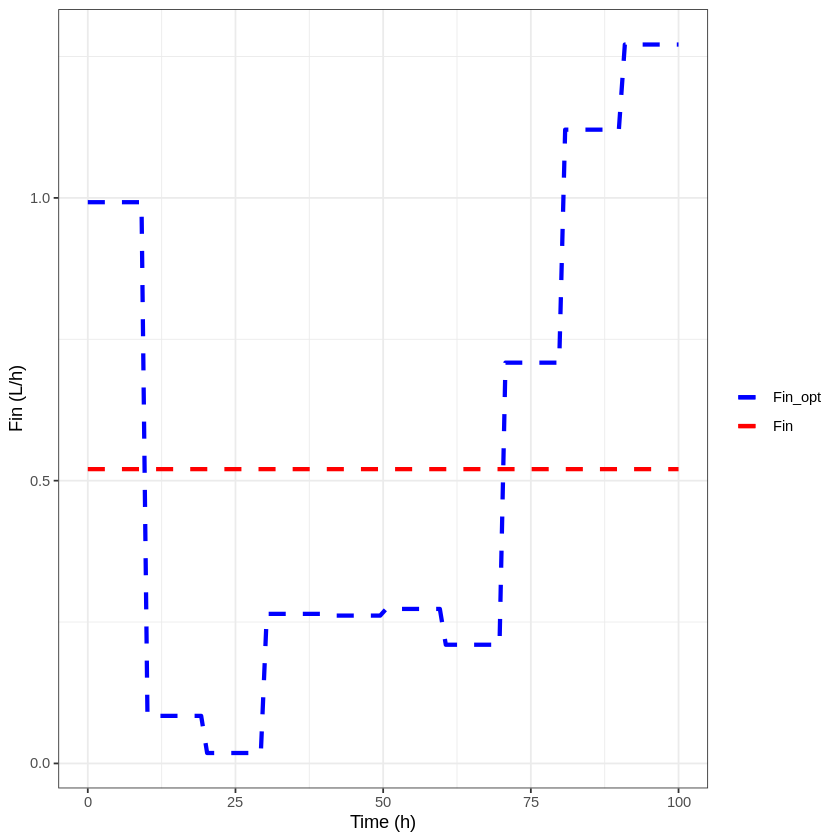

In [155]:
# mostrar resultados 
ggplot(data_opt, aes(times)) +
        geom_line(aes(y = Fin, color = "Fin_opt"), lty = 2, lwd = 1.2) +
        geom_line(data = data_no_opt, aes(y = Fin, color = "Fin"), lty = 2, lwd = 1.2) +
        scale_color_manual("", breaks = c("Fin_opt", "Fin"), values = c("blue", "red")) +
        xlab("Time (h)") +
        ylab("Fin (L/h)") +
        theme_bw()

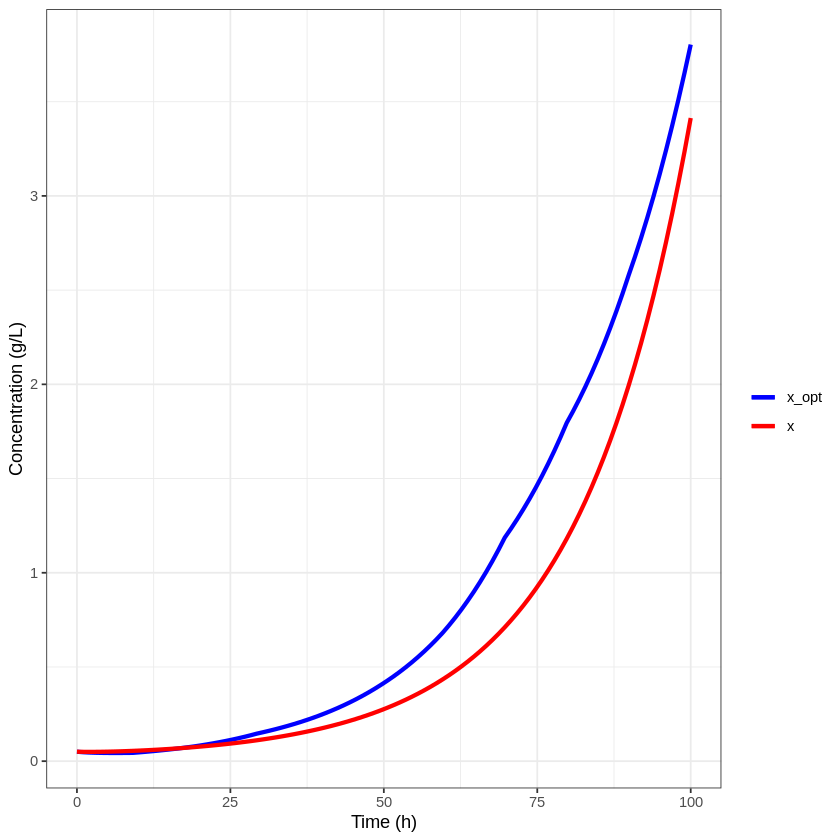

In [156]:
ggplot(data_opt, aes(times)) +
        geom_line(aes(y = x, color = "x_opt"), lty = 1, lwd = 1.2) +
        geom_line(data = data_no_opt, aes(y = x, color = "x"), lty = 1, lwd = 1.2) +
        scale_color_manual("", breaks = c("x_opt", "x"), values = c("blue", "red")) +
        xlab("Time (h)") +
        ylab("Concentration (g/L)") +
        theme_bw()

In [157]:
n <- length(data_opt$times)
mx_end <- data_no_opt$V[n]*data_no_opt$x[n]
mx_end_opt <- data_opt$V[n]*data_opt$x[n]
cat("mx_end:", mx_end, "g \n")
cat("mx_end_opt:", mx_end_opt, "g \n")
cat("diferencia: ", mx_end_opt - mx_end, "g")

mx_end: 211.7893 g 
mx_end_opt: 234.167 g 
diferencia:  22.37774 g

Vemos que existe una diferencia en la cantidad de biomasa obtenida de 18.633 g, o lo que es equivalente un 8.762 % más de biomasa. En proceso industrial en que se generan toneladas de biomasa al año, este 8.762 % puede llegar a representar una gran diferencia

### Optimización con restricciones 

Ahora consideramos el caso en que el volumen del biorreactor tiene un límite, es decir, al momento de alimentar un flujo al biorreactor debemos considerar que este tiene una capacidad máxima y no debemos sobrepasar dicha capacidad.

En el siguiente modelo consideramos que si $V > V_{lim}$ entonces $F_{in} = 0$

In [162]:
# establecer modelo 
model2 <- function(times, state, parms) {
        with(as.list(c(state,parms)), {
                
                if (V > Vl) {

                        Fin = 0
                }
                
                # velocidad de crecimiento de biomasa
                rx = mu_max*s/(ks + s + ki*s^2)*x
                
                # velocidad de consumo de sustrato
                rs = (1/Yxs)*rx

                # velocidad de consumo de sustrato
                rp = Ypx*rx
                
                # balance de material global 
                dVdt = Fin 
                
                # balance de materia para sustrato
                dsdt = Fin/V*(sf - s) - rs
                
                # balance de materia para biomasa
                dxdt = - Fin/V*x + rx
                
                # balance de materia para el producto
                dpdt = - Fin/V*p + rp

                return(list(c(dVdt, dsdt, dxdt, dpdt), Fin = Fin))
        })
}

In [163]:
# establecer parámetros 
p <- c(mu_max = 1.2, ks = 280, Yxs = 0.2, Ypx = 4, sf = 50, Fin = 1.2, ki = 0.3, Vl = 100)

In [164]:
# establecer condiciones iniciales 
s <- c(V = 10, s = 10, x = 0.05, p = 0)

In [165]:
# tiempo de integración
times <- seq(0,100,len=100)

In [168]:
# resolver EDOs
out <- ode(y = s, times = times, func = model2, parms = p, method = "rk4")
out <- as.data.frame(out)

,time,V,s,x,p,Fin
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.000000,10.00000,10.00000,0.05000000,0.000000000,1.2
2,1.010101,11.21212,14.31433,0.04659313,0.007994138,1.2
3,2.020202,12.42424,17.78461,0.04429713,0.016212907,1.2
4,3.030303,13.63636,20.63641,0.04271858,0.024207640,1.2
5,4.040404,14.84848,23.02141,0.04163583,0.031849454,1.2
6,5.050505,16.06061,25.04542,0.04091583,0.039135003,1.2


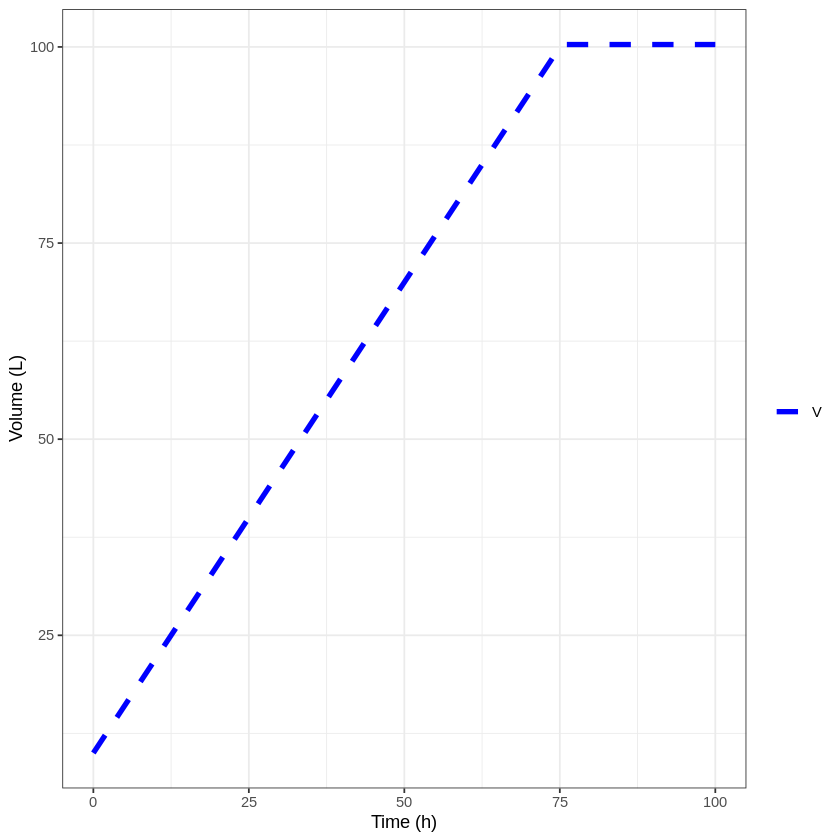

In [169]:
# mostrar resultados de simulación 
ggplot(out, aes(time)) +
  geom_line(aes(y = V, color = "V"), lty = 2, lwd = 1.5) +
  scale_color_manual("", breaks = c("V"), values = c("blue")) +
  xlab("Time (h)") +
  ylab("Volume (L)") +
  theme_bw()

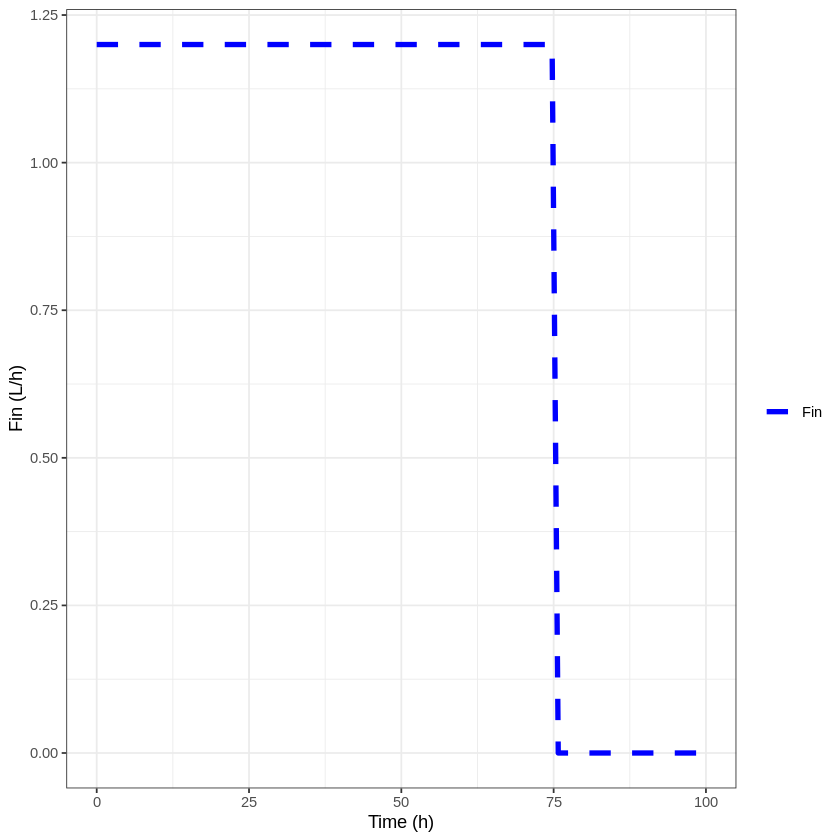

In [170]:
ggplot(out, aes(time)) +
  geom_line(aes(y = Fin, color = "Fin"), lty = 2, lwd = 1.5) +
  scale_color_manual("", breaks = c("Fin"), values = c("blue")) +
  xlab("Time (h)") +
  ylab("Fin (L/h)") +
  theme_bw()

Definimos una nueva función que nos ayude a variar el flujo de alimentación, considerando que si $V > V_{lim}$ entonces $F_{in} = 0$

In [172]:
change_input2 <- function(times, state, parms, Fin, model) {
        
        n <- length(times)
        # vectores para guardar los resultados  V0 = s[2]!
        V0 <- state[1]
        V <- rep(V0, n)
        s0 <- state[2]
        su <- rep(s0,n)
        x0 <- state[3]
        x <- rep(x0,n)
        p0 <- state[4]
        p <- rep(p0,n)
        
        # resolver EDO para los diferentes valores de Fin
        
        for (i in 1:(n-1)) {
                
                tspan <- c(times[i], times[i+1])
                
                parms["Fin"] <- Fin[i+1]
                
                # resolver EDOs
                out <- ode(y = state,
                           times = tspan,
                           func = model,
                           parms = parms,
                           method = "rk4")
                
                m <- nrow(out)
                # actualizar condiciones iniciales
                state <- out[m,c(2,3,4,5)]
                out <- as.data.frame(out)
                # guardar resultados 
                V[i+1] <- out$V[m]
                su[i+1] <- out$s[m]
                x[i+1] <- out$x[m]
                p[i+1] <- out$p[m]
                Fin[i+1] <- out$Fin[m]
        }
        
        return(list(times = times, V = V, s = su, x = x, p = p, Fin = Fin))
}

In [173]:
# perfil Fin para la simulación 
n <- length(times)
Fin <- rep(0, n)
Fin[51:n] <- 1.2

In [174]:
# simular proceso 
out <- change_input2(state = s, times = times, parms = p, Fin = Fin, model = model2)
out <- as.data.frame(out)
head(out)

,times,V,s,x,p,Fin
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.000000,10,10.000000,0.05000000,0.000000000,0
2,1.010101,10,9.990352,0.05192953,0.007718119,0
3,2.020202,10,9.980340,0.05393195,0.015727806,0
4,3.030303,10,9.969951,0.05600989,0.024039578,0
5,4.040404,10,9.959170,0.05816607,0.032664292,0
6,5.050505,10,9.947984,0.06040329,0.041613151,0


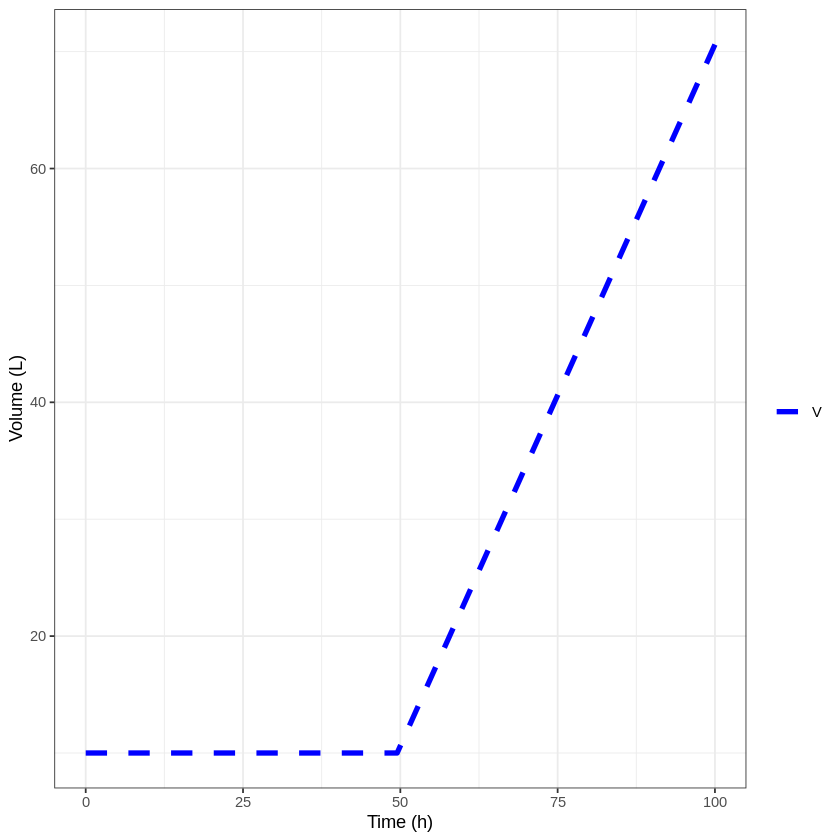

In [175]:
# mostrar resultados 
ggplot(out, aes(times)) +
        geom_line(aes(y = V, color = "V"), lty = 2, lwd = 1.5) +
        scale_color_manual("", breaks = c("V"), values = c("blue")) +
        xlab("Time (h)") +
        ylab("Volume (L)") +
        theme_bw()

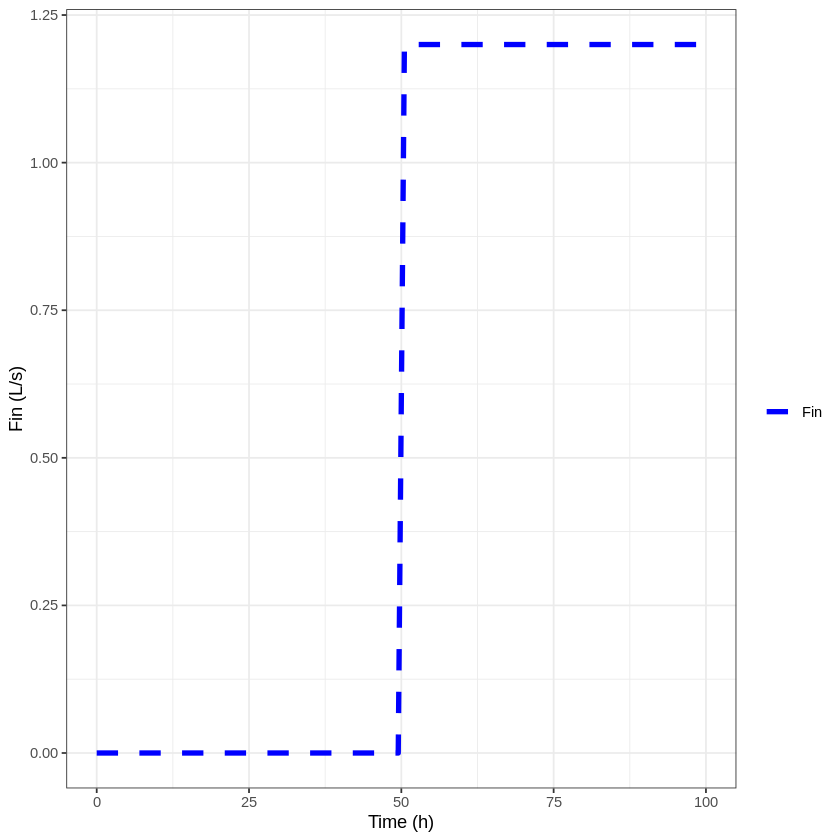

In [176]:
ggplot(out, aes(times)) +
        geom_line(aes(y = Fin, color = "Fin"), lty = 2, lwd = 1.5) +
        scale_color_manual("", breaks = c("Fin"), values = c("blue")) +
        xlab("Time (h)") +
        ylab("Fin (L/s)") +
        theme_bw()

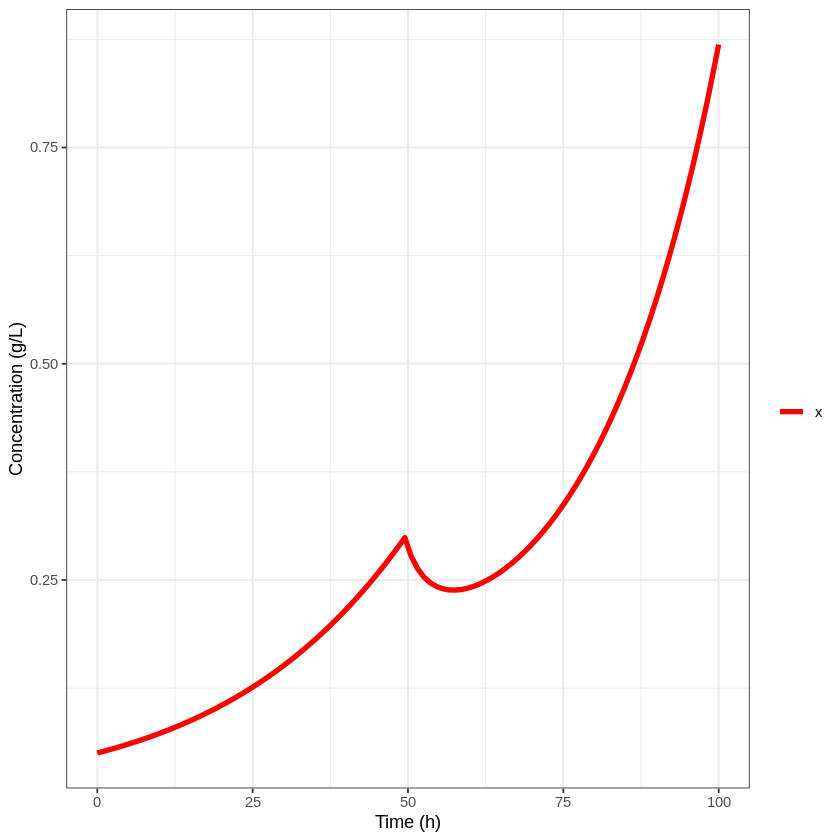

In [177]:
ggplot(out, aes(times)) +
        geom_line(aes(y = x, color = "x"), lty = 1, lwd = 1.5) +
        scale_color_manual("", breaks = c("x"), values = c("red")) +
        xlab("Time (h)") +
        ylab("Concentration (g/L)") +
        theme_bw()

Vamos a intentar encontrar el valor de $Fin$ que permite generar la mayor producción de biomasa al final de la fermentación. Consideramos el caso en que $k_i = 0.3$, $s_f = 50 g/L$, y V_{lim} = 100 L 

In [178]:
# intervalo de Fin en los que buscaremos el óptimo
Fin <- seq(0,5,len=100)
# valor de ki que nos interesa estudiar
ki <- 0.3
p["ki"] <- ki
# valor de sf que nos interesa estudiar 
sf = 50
p["sf"] <- sf

In [179]:
# realizar simulaciones para todos los valores de Fin constate 
out <- biomass3(times = times, state = s, parms = p, Fin = Fin, ki = ki, model = model2)

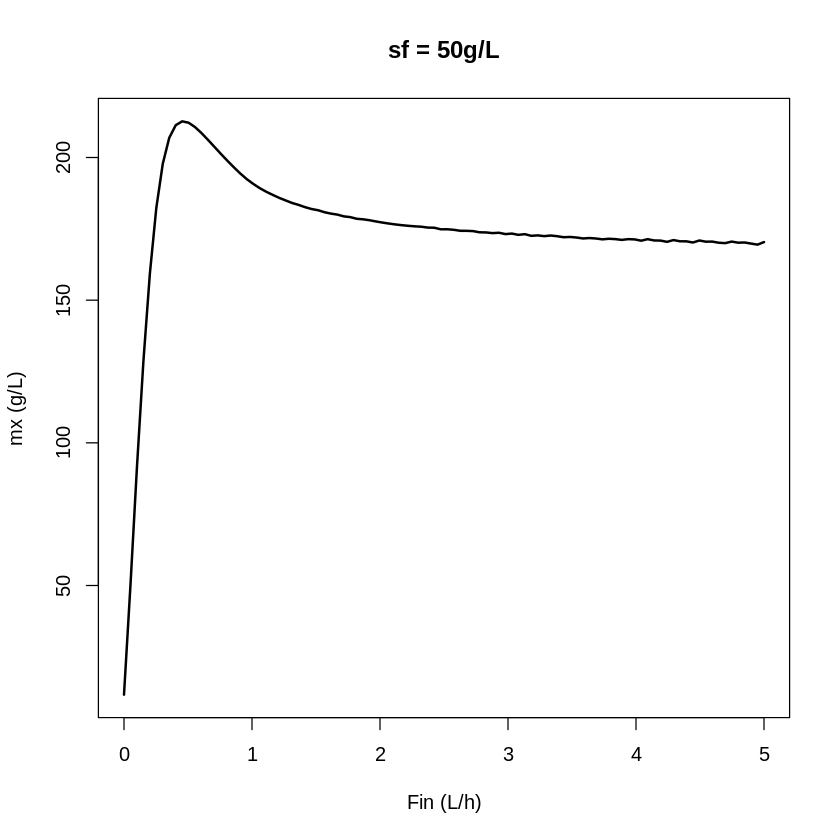

In [180]:
plot(Fin, out[[1]], ylab = "mx (g/L)", xlab = "Fin (L/h)", main = paste0("sf = ", sf, "g/L"), # biomass3() regresa una lista con vectores
     type = "l", col = 1, lwd = 2)

In [181]:
# realizar optimización 
GA <- ga(type = "real-valued",
         fitness = fitness1,
         times= times,
         state = s,
         parms = p,
         model = model2,
         lower = 0,
         upper =2,
         maxiter = 10,
         maxFitness = 1e6)

In [182]:
cat("mx_max:", GA@fitnessValue)

mx_max: 212.6872

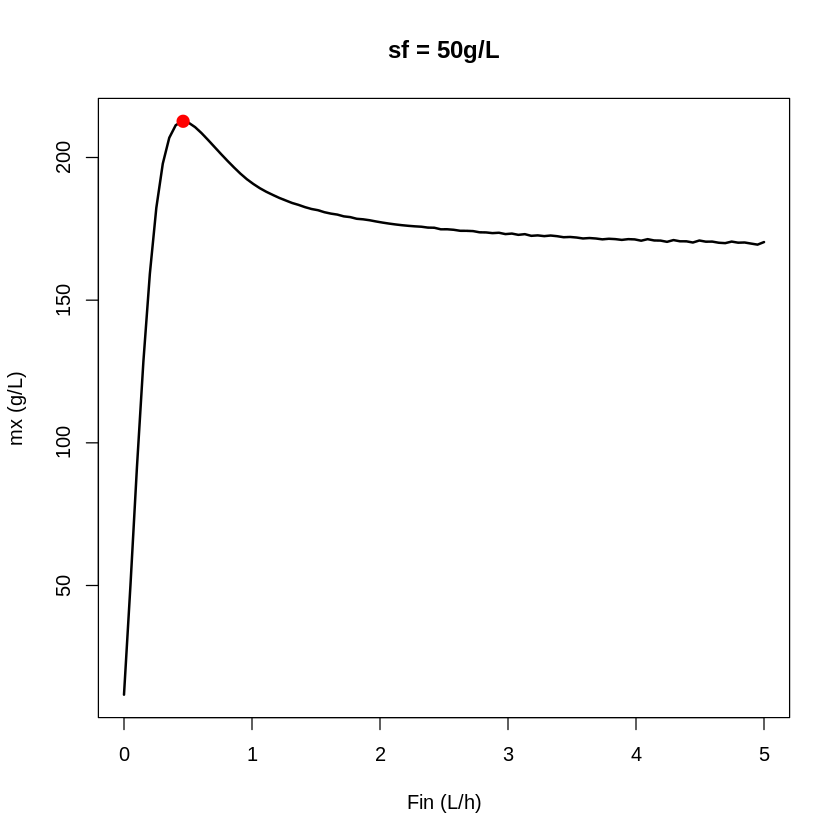

In [183]:
# graficar resultados 
plot(Fin, out[[1]], ylab = "mx (g/L)", xlab = "Fin (L/h)", main = paste0("sf = ", sf, "g/L"), # biomass3() regresa una lista con vectores
     type = "l", col = 1, lwd = 2)
points(GA@solution, GA@fitnessValue, col="red", pch = 20, cex = 2)

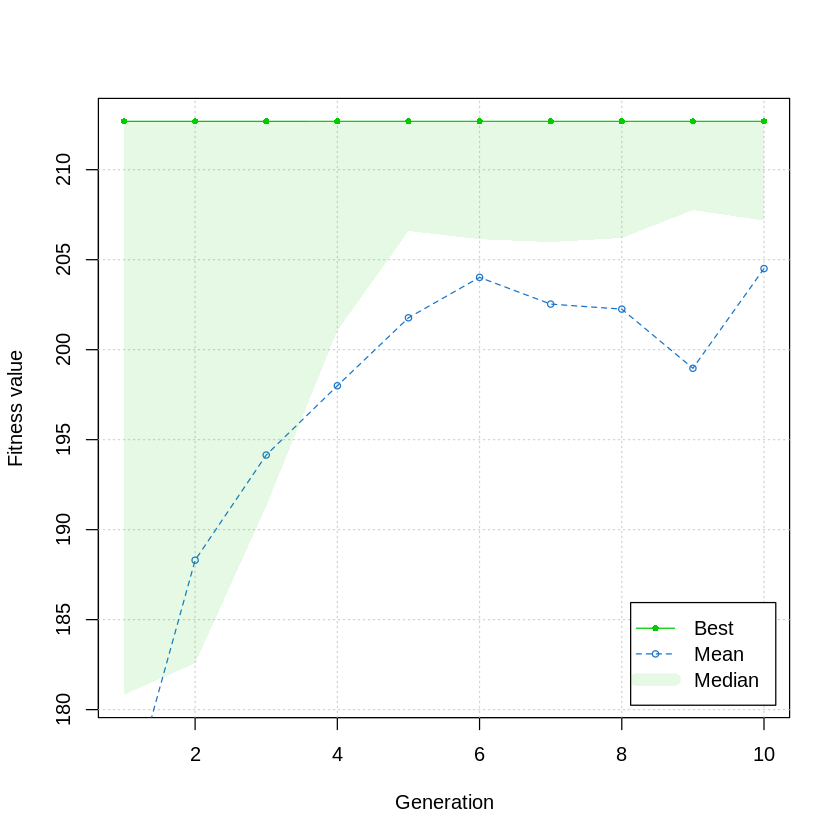

In [184]:
# evolución del GA 
plot(GA)

Ahora optimizamos para encontrar el perfil $F_{in}$ que genere una máxima producción de biomasa

In [186]:
GA2 <- ga(type = "real-valued",
          fitness = fitness2,
          times= times,
          state = s,
          parms = p,
          model2,
          lower = rep(0, 10),
          upper = rep(2, 10),
          maxiter = 100, popSize = 50)

In [187]:
cat("mx_opt:", GA2@fitnessValue, "g/L")

mx_opt: 235.8907 g/L

In [189]:
Fin_opt <- rep(GA2@solution, each = 10)

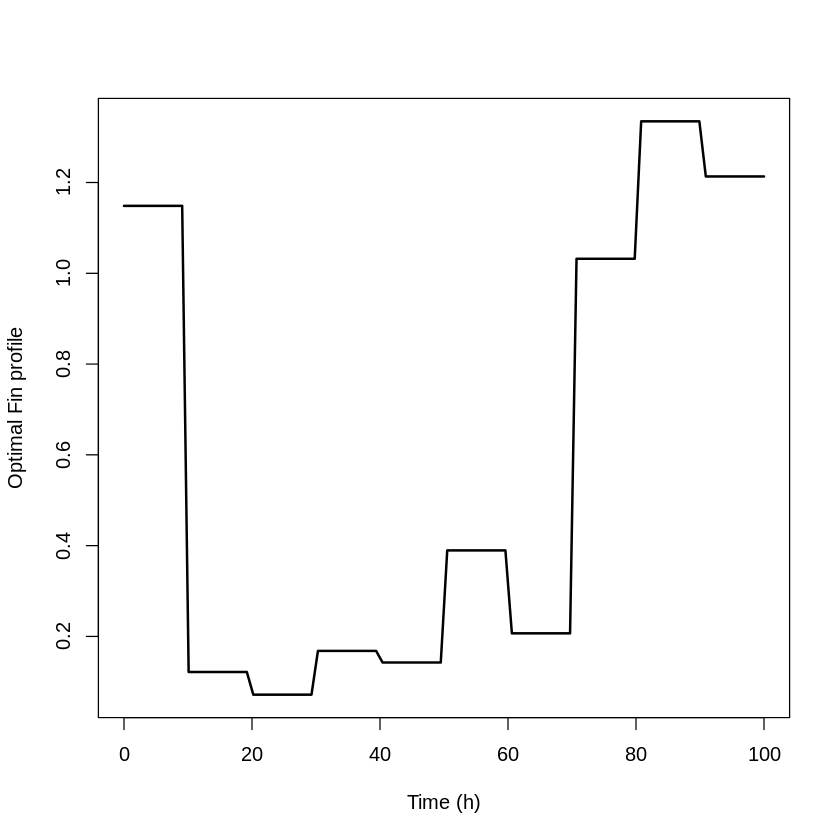

In [190]:
plot(times, Fin_opt, type = "l", lwd = 2, ylab = "Optimal Fin profile", xlab = "Time (h)")

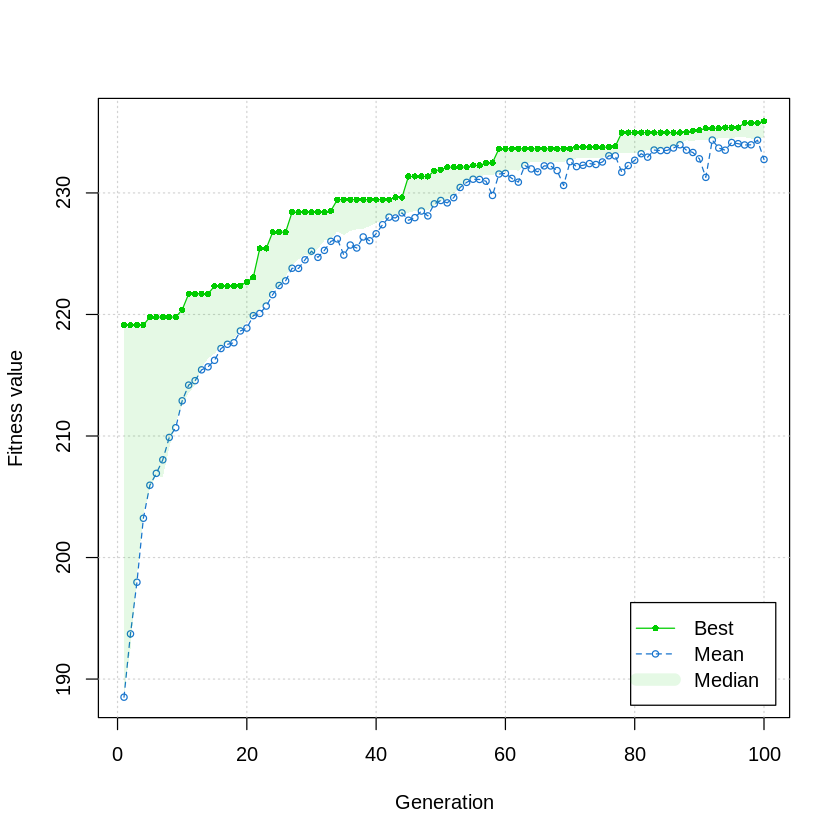

In [191]:
plot(GA2)

In [202]:
# simular con el resultado de la simulación
out <- change_input2(state = s, times = times, parms = p, Fin = Fin_opt, model = model2)
data_opt <- data.frame(times = out$times, V = out$V, s = out$s, x = out$x, p = out$p, Fin = out$Fin)


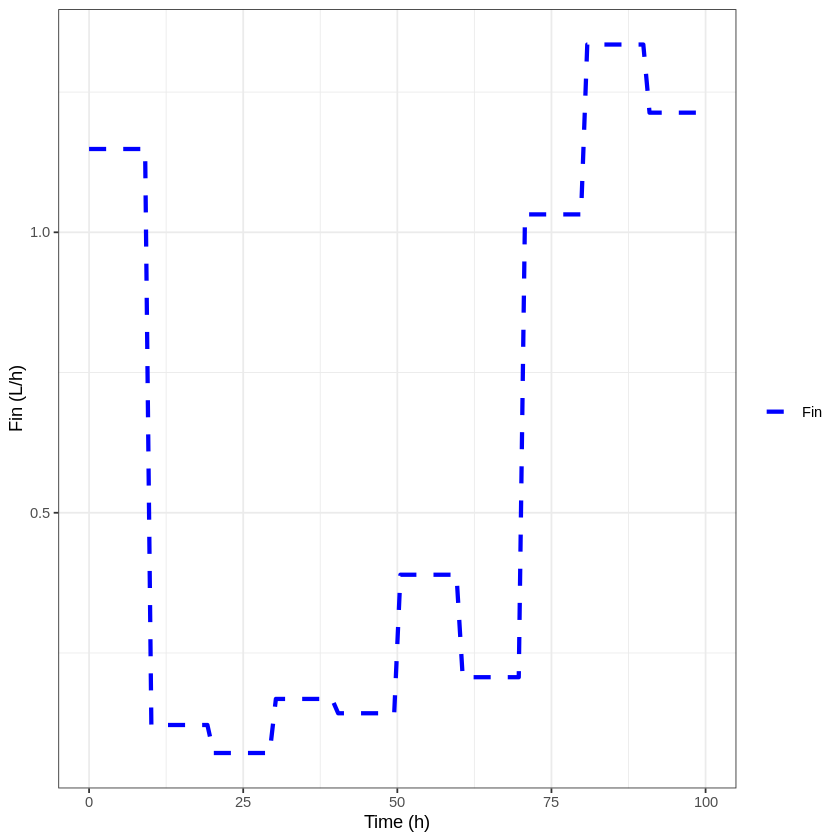

In [203]:
# mostrar resultados 
ggplot(data_opt, aes(times)) +
        geom_line(aes(y = Fin, color = "Fin"), lty = 2, lwd = 1.2) +
        scale_color_manual("", breaks = c("Fin"), values = c("blue")) +
        xlab("Time (h)") +
        ylab("Fin (L/h)") +
        theme_bw()

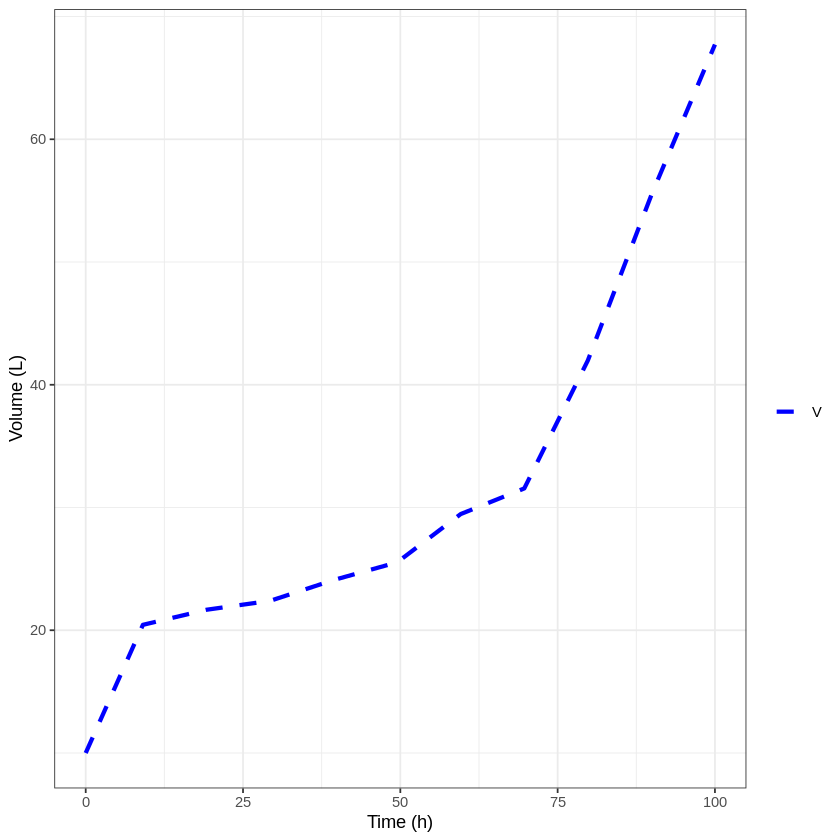

In [204]:
ggplot(data_opt, aes(times)) +
        geom_line(aes(y=V, color = "V"), lty = 2, lwd = 1.2) +
        scale_color_manual("", breaks = c("V"), values = c("blue")) +
        xlab("Time (h)") +
        ylab("Volume (L)") +
        theme_bw()

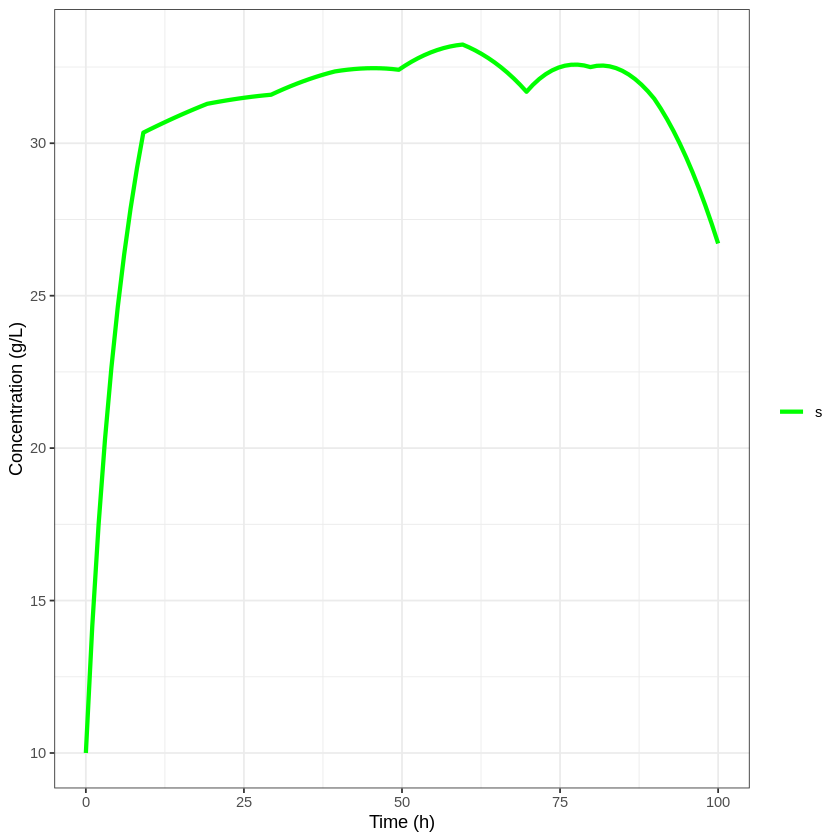

In [205]:
ggplot(data_opt, aes(times)) +
        geom_line(aes(y=s, color = "s"), lty = 1, lwd = 1.2) +
        scale_color_manual("", breaks = c("s"), values = c("green")) +
        xlab("Time (h)") +
        ylab("Concentration (g/L)") +
        theme_bw()

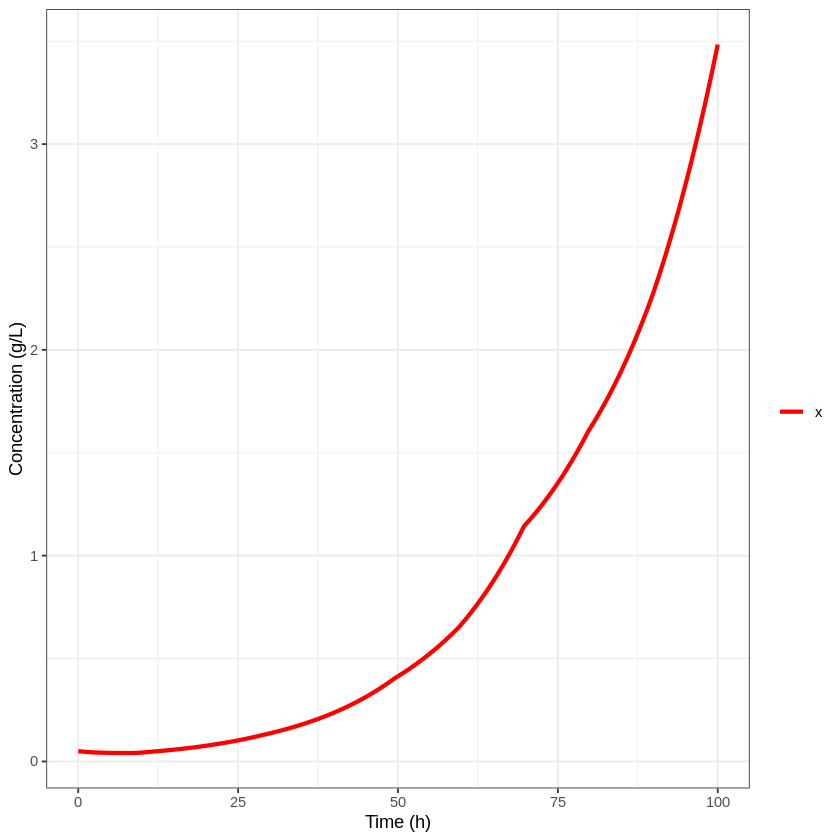

In [206]:
ggplot(data_opt, aes(times)) +
        geom_line(aes(y=x, color = "x"), lty = 1, lwd = 1.2) +
        scale_color_manual("", breaks = c("x"), values = c("red")) +
        xlab("Time (h)") +
        ylab("Concentration (g/L)") +
        theme_bw()